talk about dual modality of data, 
check if there are strang trip durations
split data before finding count
.unique so that rows aren't repeated
ridge or lasso?
add comment about why start and end stations aren't the same

## Intro to Business Analytics Assignment 1

### Contributors
- Stanisław Howard, s231719
- Alexis Van den Heede, s231860
- Matthias Van Mechelen
- Sven Palac, s231799
- Salar Ravangouy Mytouei, s232038


### stuff to add after reading peer reviews:  
- yes theree are birthyears of 1880 but that doesnt make the trips irrelevant, maybe joke of teenager that put old age or something, the trips are still relevant
- Plot alexis sent Matthias about plotting the data per hour for each day, result of hist: you see a morning and evening peak on the weekdays and and no peaks in the weekends. 
- use elbow method for k means rather than just 20?
- Are there NaNs in the gender column? (one of the reports stated that: So we are dealing with just over 4 million faulty values. That means almost 25% of our dataset cannot be used for gender specific analysis.Another observation is, that we have registerd almost 12 million trips undertaken by men, while we have only abbout 1.5 million trips undertaken by women. And the vast majority of these 1.5 million trips done by women between 50 and 55 years of age.)
- Station 530 switched location 30-11-2018 (see peer review 3, but this is only one station, so maybe not worth mentioning)
- look at peer report 3, very nice initial analysis, some more relevant than other, and they top it off with an insane prediciton model. 
- Add ones to the x_train
- Transpose y values


In [14]:
import pandas as pd
import numpy as np
import os 
import sys
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import datetime

In [15]:
df = pd.read_csv('data/Trips_2018.csv')

In [16]:
# Delete this later !!!!!!!!!!!!!!!!!!!!!!!
df_copy = df.copy()
df.head()

,Unnamed: 0,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,0,970,2018-01-01 13:50:57.4340,2018-01-01 14:07:08.1860,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1
1,1,723,2018-01-01 15:33:30.1820,2018-01-01 15:45:33.3410,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1
2,2,496,2018-01-01 15:39:18.3370,2018-01-01 15:47:35.1720,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1
3,3,306,2018-01-01 15:40:13.3720,2018-01-01 15:45:20.1910,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1
4,4,306,2018-01-01 18:14:51.5680,2018-01-01 18:19:57.6420,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1


In [17]:
# rerun this to save time if you make a typo and need original df again
df = df_copy.copy()

Once we imported our data we need to inspect the content. As we can see a couple things need to be immediatelly handled. For instance checking datatypes, missing values, duplicates and making sure the data is in the right format. We also need to handle the categorical values correctly.

In [18]:
### Let's check the datatypes first
df.dtypes

Unnamed: 0                   int64
tripduration                 int64
starttime                   object
stoptime                    object
start_station_id           float64
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_latitude       float64
end_station_longitude      float64
bikeid                       int64
usertype                    object
birth_year                   int64
gender                       int64
dtype: object

In [19]:
# col 0 is unnamed, change name to trip_id convert column to index
df.rename(columns={'Unnamed: 0':'trip_id'}, inplace=True)
df.set_index('trip_id', inplace=True)

In [20]:
#  convert start time and stop time to datetime objects
df['starttime'] = pd.to_datetime(df['starttime'], format="%Y-%m-%d %H:%M:%S.%f")
df['stoptime'] = pd.to_datetime(df['stoptime'], format="%Y-%m-%d %H:%M:%S.%f")

In [21]:
# get rid of categorical datatype which is the user subscriber type
df = pd.get_dummies(df, columns=['usertype'], dtype=int, drop_first=True)


As we can see all the datatypes have been handled. It is time to inspect actual values of the dataframe. We will look at the distribution of particular columns and check for outliers. We will also check for duplicates and missing values. 

Let's first look at the locations of the stations.

In [22]:
# plotting coordinates
def plot_map(coords):
    plt.scatter(coords[:,0], coords[:,1], s=0.75)
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    plt.show()

def plot_map_with_background(coords):
    folder_path = 'data/nyc_folder'
    shapefiles = [file for file in os.listdir(folder_path) if file.endswith('.shp')]
    gdf = gpd.read_file(os.path.join(folder_path, shapefiles[0]))
    ax = gdf.plot(figsize=(10, 10), alpha=0.1, edgecolor='k')
    plt.title(f"Visualization of Stations in NYC")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    ### plot the coordinates on the map
    plt.scatter(coords[:,0], coords[:,1], s=0.75, c='blue')
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    plt.show()

In [23]:
coords = df[['start_station_longitude','start_station_latitude']].values
coords = np.unique(coords, axis=0)



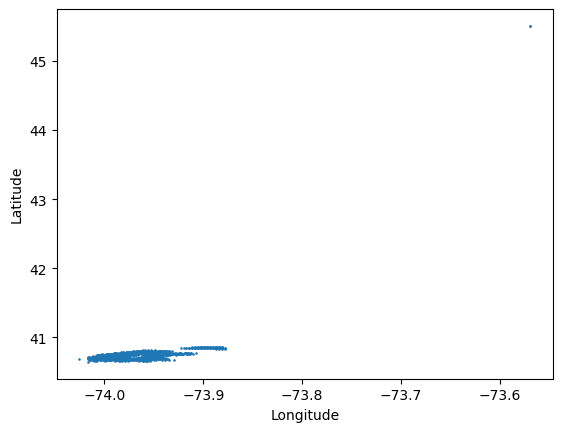

In [24]:
#plot innitial coordinates
plot_map(coords)


Notice outlier (Canada, Montreal). quickly get rid of it to get an overview of the rest of the data. We will not yet delete the outlier datapoint from the dataframe.

In [25]:
# get rid of outlier longitude > -73.6
coords = coords[coords[:,0] < -73.6]
print(coords.shape) #shape is 917 here as it still includes the grid anomalies

(917, 2)


After removing the outlier we can see that the stations are located in the New York area. There still are a group of stations that seem odly located. Let's plot them on a map to see where they are located.

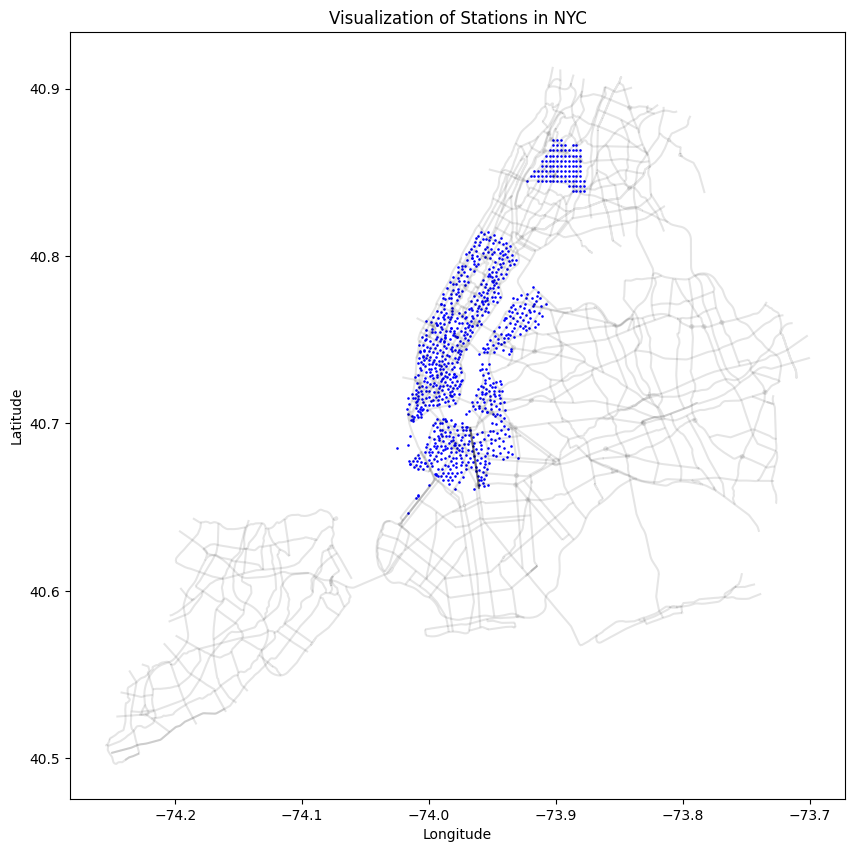

In [27]:
plot_map_with_background(coords)

Notice very structured grid in top right corner. After investigation these data points were NaN's. We will rid of these data points, and at the same time we get rid of the canada outlier. 

In [28]:
# print where nan is in df, get rid of nan (= get rid of gridded outliers), create copy of df and start station coordinates
print(df.isnull().sum())
df = df[~np.isnan(df['start_station_id'])]
df = df[~np.isnan(df['end_station_id'])]
# get rid of Canada outlier
df = df[df['start_station_longitude'] < -73.6]
df = df[df['end_station_longitude'] < -73.6]
# get lat and long
coords_start = df[['start_station_longitude','start_station_latitude']].values
coords_start = np.unique(coords_start, axis=0)
coords_start_copy = coords_start.copy()
print(coords.shape)

tripduration                  0
starttime                     0
stoptime                      0
start_station_id           2497
start_station_latitude        0
start_station_longitude       0
end_station_id             2497
end_station_latitude          0
end_station_longitude         0
bikeid                        0
birth_year                    0
gender                        0
usertype_Subscriber           0
dtype: int64
(917, 2)


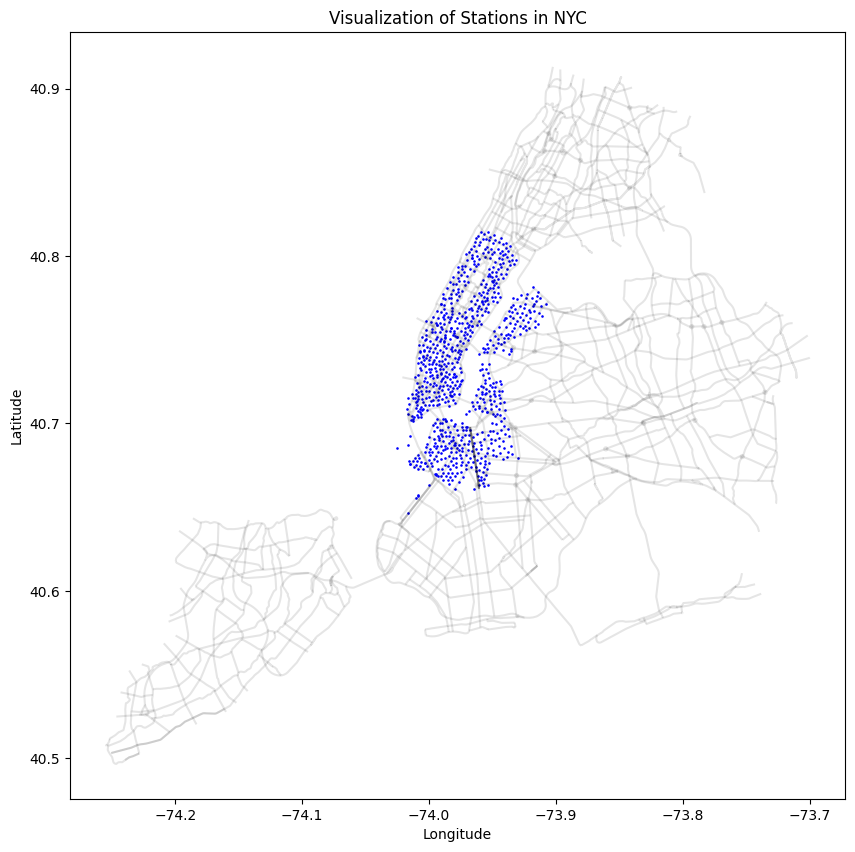

In [29]:
plot_map_with_background(coords_start)

In [30]:
# amount of distinct end stations does not match amount of start stations as seen from comparing shapes, create copy of end station coordinates.
coords_end = df[['end_station_longitude','end_station_latitude']].values
coords_end = np.unique(coords_end, axis=0)
print(coords_end.shape)
print(coords_start.shape)
coords_end_copy = coords_end.copy()


(849, 2)
(817, 2)


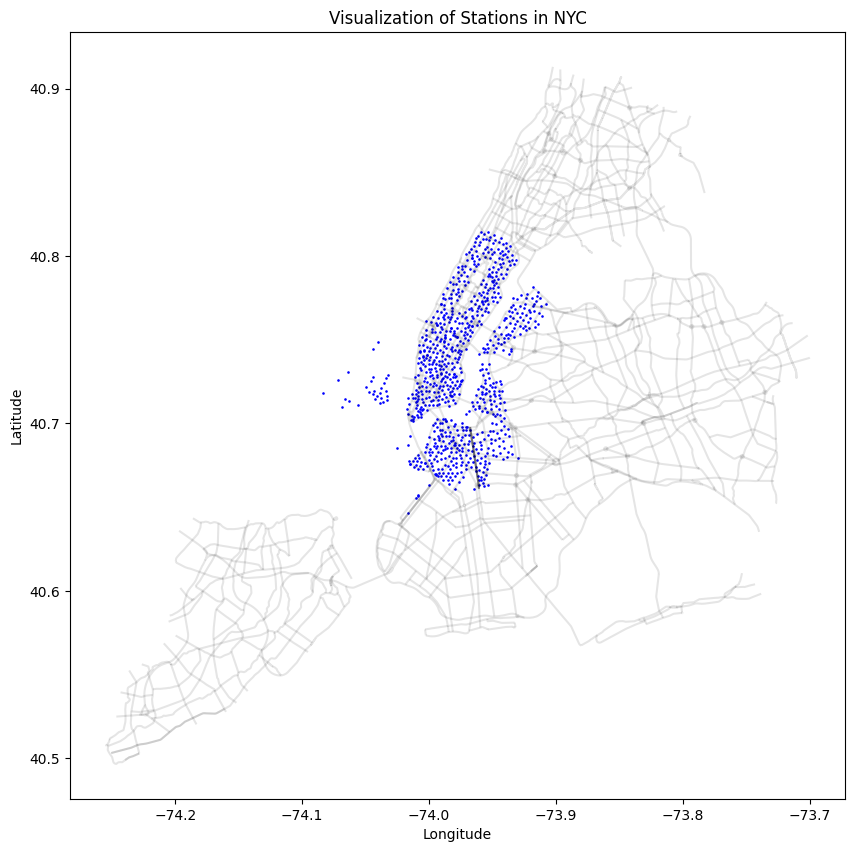

In [31]:
#what does the difference look like visually?
plot_map_with_background(coords_end)

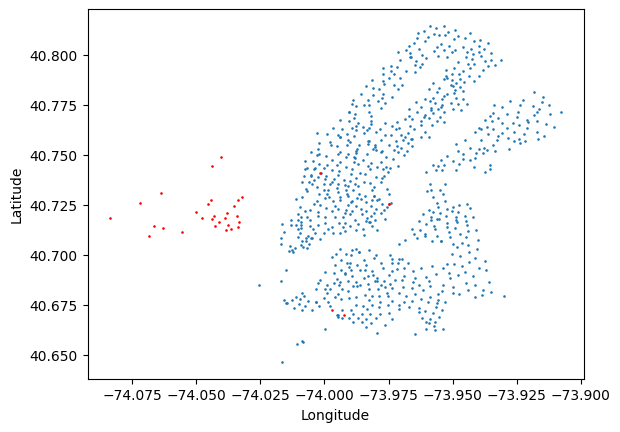

In [32]:
# highlight the end stations that are not in the start stations on the map of all en
coords_end_not_in_start = []
for i in range(len(coords_end)):
    if coords_end[i] not in coords_start:
        coords_end_not_in_start.append(coords_end[i])
coords_end_not_in_start = np.array(coords_end_not_in_start)
plt.scatter(coords_start[:,0], coords_start[:,1], s=0.75)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.scatter(coords_end_not_in_start[:,0], coords_end_not_in_start[:,1], s=0.75, c='r')
plt.show()


Since there are more end stations than start stations and all start stations are also an end station, the clustering should be done using the end stations in order to cluster every station considered in the data. 

Now let's look into the distribution of ages.

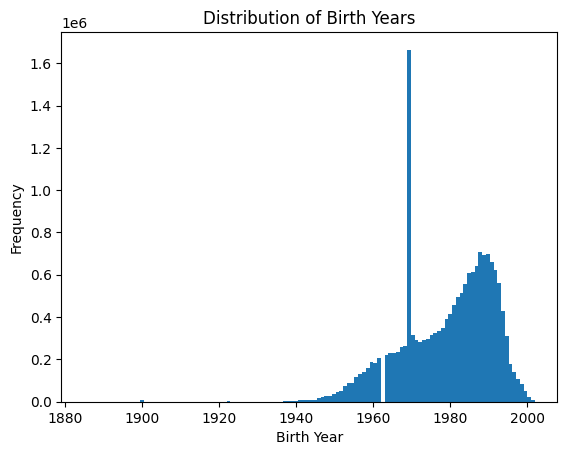

In [33]:
# plot the distribution of the ages of the users
plt.hist(df['birth_year'], bins=120)
plt.xlabel('Birth Year')
plt.ylabel('Frequency')
plt.title('Distribution of Birth Years')
plt.show()



As we can see the distribution of ages dominated by the year 1969. Upon further inspection we believe this is caused that when a user is not logged in, the birthyear is set to 1969. Because of that we will not use the birth year in prediction as we have no mean of incoporating this data in a meaningful way.

## Part 1
Clustering the stations

In [34]:
# import kmeans
from sklearn.cluster import KMeans

In [35]:
n_clusters = 20
random_state = 0

In [36]:
# make kmeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(coords_end) # using coords here instead of df to increase speed

C:\Users\Matth\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Train on coords instead of DataFrame to increase speed, then predict to save labels on df, model is trained on same data as you predict the cluster for, so the cluster they belong to will be the same one as they belonged to during convergence of the Kmeans cluster.

In [37]:
df['drop_label'] = kmeans.predict(df[['end_station_longitude','end_station_latitude']].values)
df['pick_label'] = kmeans.predict(df[['start_station_longitude','start_station_latitude']].values)
df_copy2 = df.copy()


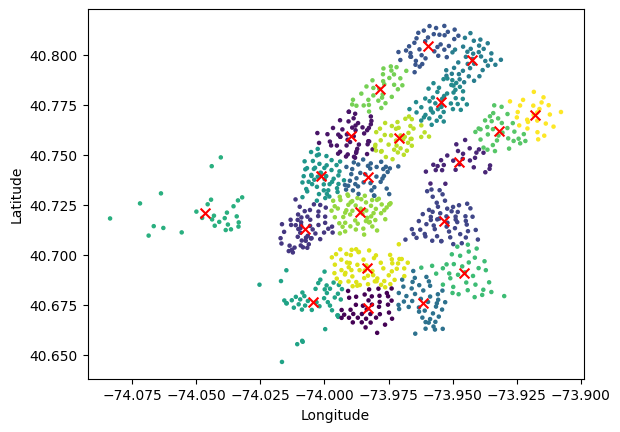

In [38]:
# plot with cluster colour & centriods
plt.scatter(coords_end[:,0], coords_end[:,1], c=kmeans.labels_, s=5)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='red', marker="x", s=50)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()

In [39]:
# run this cell for coords of starting stations and the fully edited dataframe
coords_start = coords_start_copy.copy()
coords_end = coords_end_copy.copy()
df = df_copy2.copy()
print(df.shape) # to check if no data loss, should be (17548339, 15)
df.head()


(17545760, 15)


,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,birth_year,gender,usertype_Subscriber,drop_label,pick_label
trip_id,,,,,,,,,,,,,,,
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,1992,1,1,1,1
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,1969,1,1,1,1
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,1956,1,1,1,1
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,1974,1,1,1,1
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,1992,1,1,15,1


## Part 2

You can lag everything. Same reason as why you could use lags on counts in model: you know all these at moment of prediction as you only ever predict at the future moment when you have info on all the lags. So you know all lags on all other variables as well!!! This entire section rests on the assumption that you can do this, so make clear. 


We need to predict the following

In [626]:
df = df_copy2.copy()
# find n largest pick cluster, randomly chose pick label over drop label 
# made to be 20 for part 3 as we need all clusters to have models
n = 19 #cluster 12 only has arrivals, so we exclude it, otherwise it breaks our models since the departure array is empty..
largest_cluster = df['drop_label'].value_counts().nlargest(n).index[:n]
print(largest_cluster)
# get all rows with largest cluster 
df = df[df['pick_label'].isin(largest_cluster)]


Index([10, 1, 16, 6, 3, 17, 18, 4, 15, 9, 5, 0, 7, 11, 8, 13, 2, 14, 19], dtype='int32', name='drop_label')


In [627]:
# #make dummies for gender, dont drop any as we need all columns for a later cell: 
df = pd.get_dummies(df, columns=['gender'], dtype=int)



In [628]:
df.head()

print(df['gender_2'].sum())

4091942


In [629]:
# # 1st plot amount of predictions per hour per cluster 
# grouby_label = df.groupby(['pick_label', df['starttime'].dt.hour]).size().reset_index(name='count')
# grouby_label = grouby_label.pivot(index='starttime', columns='pick_label', values='count')
# grouby_label.plot(figsize=(20,10), legend=True)
# plt.ylabel('Count')
# plt.xlabel('Hour')
# plt.show()

Start by splitting up the dataset. Necessary because how are you going to aggregate the data by hour if each datapoint has 2 temporal parameters (start and end station times). Note that we can only use the hour and cluster as input to our model, as these are the only variables we have certain information on for the future datapoints for which we predict the demand, so we only have to copy these variables over in the new datasets. 

In [630]:
df_departures = df[['starttime', 'pick_label', 'tripduration', 'gender_0', 'gender_1', 'gender_2', 'usertype_Subscriber']].copy()
df_arrivals = df[['stoptime', 'drop_label', 'tripduration', 'gender_0', 'gender_1', 'gender_2', 'usertype_Subscriber']].copy()

# rename label columns
df_departures.rename(columns={'pick_label':'label'}, inplace=True)
df_arrivals.rename(columns={'drop_label':'label'}, inplace=True)

# Extract date and time components
def extract_date_time_components(df, time_column):
    df['hour'] = df[time_column].dt.hour
    df['date'] = df[time_column].dt.date
    df['month'] = df[time_column].dt.month
    ##### df['days_from_beg_of_year'] = df[time_column].dt.dayofyear
    df.drop(columns=[time_column], inplace=True)

extract_date_time_components(df_departures, 'starttime')
extract_date_time_components(df_arrivals, 'stoptime')

# Remove trip_id index
df_departures.reset_index(drop=True, inplace=True)
df_arrivals.reset_index(drop=True, inplace=True)

# function to split data into train and test set train if month < 11, test if month >= 11
def split_train_test(df):
    df_train = df[df['month'] < 11]
    df_test = df[df['month'] >= 11]
    return df_train, df_test


# Count the number of rows with the same label, hour, and save it in a new column
def count(df):
    ##### counts = df.groupby(['label', 'hour', 'day', 'month']).size().reset_index(name='count')
    ##### df = df.merge(counts, on=['label', 'hour', 'day', 'month'], how='left')
    counts = df.groupby(['label', 'hour', 'date']).size().reset_index(name='count')
    print(counts)
    df = df.merge(counts, on=['label', 'hour', 'date'], how='left')
    return df

# Find the average trip duration for each label, hour, date and save it in a new column
def avg_tripduration(df):
    ##### avg_tripduration = df.groupby(['label', 'hour', 'day', 'month'])['tripduration'].mean().reset_index(name='avg_tripduration')
    ##### df = df.merge(avg_tripduration, on=['label', 'hour', 'day', 'month'], how='left')
    avg_tripduration = df.groupby(['label', 'hour', 'date'])['tripduration'].mean().reset_index(name='avg_tripduration')
    print(avg_tripduration)
    df = df.merge(avg_tripduration, on=['label', 'hour', 'date'], how='left')
    return df

# Find the percentage of males, females, and unknowns for each label, hour, date and save it in a new column
def avg_gender(df):
    percentage_gender_0 = df.groupby(['label', 'hour', 'date'])['gender_0'].mean().reset_index(name = 'percentage_gender_0')
    percentage_gender_1 = df.groupby(['label', 'hour', 'date'])['gender_1'].mean().reset_index(name = 'percentage_gender_1')
    percentage_gender_2 = df.groupby(['label', 'hour', 'date'])['gender_2'].mean().reset_index(name = 'percentage_gender_2')
    print(percentage_gender_0)
    print(percentage_gender_1)
    print(percentage_gender_2)
    df = df.merge(percentage_gender_0, on=['label', 'hour', 'date'], how='left')
    df = df.merge(percentage_gender_1, on=['label', 'hour', 'date'], how='left')
    df = df.merge(percentage_gender_2, on=['label', 'hour', 'date'], how='left')
    return df
    
# Split data into train and test set
df_departures_train, df_departures_test = split_train_test(df_departures)
df_arrivals_train, df_arrivals_test = split_train_test(df_arrivals)

# Count the number of rows with the same label, hour, and save it in a new column
df_departures_train = count(df_departures_train)
df_departures_test = count(df_departures_test)
df_arrivals_train = count(df_arrivals_train)
df_arrivals_test = count(df_arrivals_test)

# Find the average trip duration for each label, hour, date and save it in a new column
df_departures_train = avg_tripduration(df_departures_train)
df_departures_test = avg_tripduration(df_departures_test)
df_arrivals_train = avg_tripduration(df_arrivals_train)
df_arrivals_test = avg_tripduration(df_arrivals_test)



# Find the average gender for each label, hour, date and save it in a new column
df_departures_train = avg_gender(df_departures_train)
df_departures_test = avg_gender(df_departures_test)
df_arrivals_train = avg_gender(df_arrivals_train)
df_arrivals_test = avg_gender(df_arrivals_test)

# print(df_departures_train)


        label  hour        date  count
0           0     0  2018-01-01      3
1           0     0  2018-01-03      1
2           0     0  2018-01-04      2
3           0     0  2018-01-06      1
4           0     0  2018-01-09      7
...       ...   ...         ...    ...
133814     19    23  2018-10-27      5
133815     19    23  2018-10-28      2
133816     19    23  2018-10-29     10
133817     19    23  2018-10-30     10
133818     19    23  2018-10-31     11

[133819 rows x 4 columns]
       label  hour        date  count
0          0     0  2018-11-01     13
1          0     0  2018-11-02     16
2          0     0  2018-11-03     16
3          0     0  2018-11-04     17
4          0     0  2018-11-05      5
...      ...   ...         ...    ...
26878     19    23  2018-12-26      4
26879     19    23  2018-12-27      4
26880     19    23  2018-12-28     10
26881     19    23  2018-12-29      4
26882     19    23  2018-12-30      3

[26883 rows x 4 columns]
        label  hour    

In [631]:
#drop month
df_departures_train.drop(columns=['month'], inplace=True)
df_departures_test.drop(columns=['month'], inplace=True)
df_arrivals_train.drop(columns=['month'], inplace=True)
df_arrivals_test.drop(columns=['month'], inplace=True)

#drop tripduration
df_departures_train.drop(columns=['tripduration'], inplace=True)
df_departures_test.drop(columns=['tripduration'], inplace=True)
df_arrivals_train.drop(columns=['tripduration'], inplace=True)
df_arrivals_test.drop(columns=['tripduration'], inplace=True)

#drop gender_0, gender_1 and gender_2 dummies
df_departures_train.drop(columns=['gender_0', 'gender_1', 'gender_2'], inplace=True)
df_departures_test.drop(columns=['gender_0', 'gender_1', 'gender_2'], inplace=True)
df_arrivals_train.drop(columns=['gender_0', 'gender_1', 'gender_2'], inplace=True)
df_arrivals_test.drop(columns=['gender_0', 'gender_1', 'gender_2'], inplace=True)

#drop usertype_Subscriber
df_departures_train.drop(columns=['usertype_Subscriber'], inplace=True)
df_departures_test.drop(columns=['usertype_Subscriber'], inplace=True)
df_arrivals_train.drop(columns=['usertype_Subscriber'], inplace=True)
df_arrivals_test.drop(columns=['usertype_Subscriber'], inplace=True)

# # reset index
# df_departures_train.reset_index(inplace=True)
# df_departures_test.reset_index(inplace=True)
# df_arrivals_train.reset_index(inplace=True)
# df_arrivals_test.reset_index(inplace=True)

# #drop column "index"
# df_departures_train.drop(columns=['index'], inplace=True)
# df_departures_test.drop(columns=['index'], inplace=True)
# df_arrivals_train.drop(columns=['index'], inplace=True)
# df_arrivals_test.drop(columns=['index'], inplace=True)

#sort data by label, hour, date
df_departures_train.sort_values(by=['date', 'hour'], inplace=True)
df_departures_test.sort_values(by=['date', 'hour'], inplace=True)
df_arrivals_train.sort_values(by=['date', 'hour'], inplace=True)
df_arrivals_test.sort_values(by=['date', 'hour'], inplace=True)

# keep unique rows
df_departures_train.drop_duplicates(inplace=True)
df_departures_test.drop_duplicates(inplace=True)
df_arrivals_train.drop_duplicates(inplace=True)
df_arrivals_test.drop_duplicates(inplace=True)


In [632]:
df_departures_train.head(20)

,label,hour,date,count,avg_tripduration,percentage_gender_0,percentage_gender_1,percentage_gender_2
6559,10,0,2018-01-01,15,504.666667,0.000000,0.733333,0.266667
10013,3,0,2018-01-01,11,628.909091,0.000000,0.727273,0.272727
82527,6,0,2018-01-01,16,634.062500,0.000000,0.750000,0.250000
87932,16,0,2018-01-01,14,828.071429,0.000000,0.857143,0.142857
122114,18,0,2018-01-01,3,304.000000,0.000000,0.666667,0.333333
170475,7,0,2018-01-01,4,574.250000,0.000000,0.750000,0.250000
262500,1,0,2018-01-01,15,890.266667,0.400000,0.600000,0.000000
284913,4,0,2018-01-01,9,754.666667,0.000000,0.777778,0.222222
397584,17,0,2018-01-01,1,1429.000000,0.000000,1.000000,0.000000
467486,13,0,2018-01-01,3,700.666667,0.000000,1.000000,0.000000


In [633]:
df_departures_test.head(20)

,label,hour,date,count,avg_tripduration,percentage_gender_0,percentage_gender_1,percentage_gender_2
0,19,0,2018-11-01,8,274.250000,0.000000,0.625000,0.375000
1,10,0,2018-11-01,88,744.965909,0.056818,0.806818,0.136364
2,0,0,2018-11-01,13,735.538462,0.000000,0.769231,0.230769
3,9,0,2018-11-01,18,787.777778,0.055556,0.888889,0.055556
4,6,0,2018-11-01,72,690.513889,0.041667,0.805556,0.152778
5,3,0,2018-11-01,22,950.272727,0.000000,0.863636,0.136364
6,7,0,2018-11-01,14,562.714286,0.000000,0.785714,0.214286
7,17,0,2018-11-01,16,797.375000,0.000000,0.875000,0.125000
10,8,0,2018-11-01,11,446.090909,0.000000,0.818182,0.181818
11,1,0,2018-11-01,53,798.811321,0.018868,0.886792,0.094340


In [634]:
df_arrivals_train.head()

,label,hour,date,count,avg_tripduration,percentage_gender_0,percentage_gender_1,percentage_gender_2
6559,6,0,2018-01-01,15,457.800000,0.00,0.666667,0.333333
10013,3,0,2018-01-01,5,283.000000,0.00,1.000000,0.000000
16541,16,0,2018-01-01,11,489.727273,0.00,0.818182,0.181818
44550,10,0,2018-01-01,16,590.812500,0.25,0.625000,0.125000
122114,18,0,2018-01-01,3,421.333333,0.00,1.000000,0.000000


In [635]:
df_arrivals_test.head()

,label,hour,date,count,avg_tripduration,percentage_gender_0,percentage_gender_1,percentage_gender_2
34,5,0,2018-11-01,23,2186.391304,0.043478,0.739130,0.217391
36,9,0,2018-11-01,15,2733.266667,0.066667,0.800000,0.133333
41,16,0,2018-11-01,98,972.255102,0.122449,0.642857,0.234694
45,11,0,2018-11-01,12,3165.416667,0.083333,0.500000,0.416667
49,13,0,2018-11-01,23,1150.478261,0.130435,0.739130,0.130435


In [636]:
#check sizes 
print(df_departures_train.shape)
print(df_departures_test.shape)
print(df_arrivals_train.shape)
print(df_arrivals_test.shape)

(133819, 8)
(26883, 8)
(134520, 8)
(26994, 8)


note: days close to eachother being linked in prediction is already included in the model as you have days and months in your model. And i dont think that it matters that i split up days and months (my guess what taht the model believes the first day of each month is closely related which it isnt. But the month is also included, nevertheless it is a fair thought. Maybe it is better to include the day and month as a counter instead, this will avoid the first day of each month being related! (as yes the months differentiate them, but the first of jun is still close in dist to the first of jan in my method, while with a continuous counter this would really not be the case. Change later

In [637]:
# function to split x and y data
# def create_x_y(df):
#     x = df[['hour', 'label', 'date']]
#     y = df['count'].T
#     return x, y


In [638]:
print(largest_cluster.shape)
print(largest_cluster)

(19,)
Index([10, 1, 16, 6, 3, 17, 18, 4, 15, 9, 5, 0, 7, 11, 8, 13, 2, 14, 19], dtype='int32', name='drop_label')


In [639]:
# split data per label for n
for i in range(n):
    globals()['df_departures_train_{}'.format(i)] = df_departures_train[df_departures_train['label'] == largest_cluster[i]]
    globals()['df_departures_test_{}'.format(i)] = df_departures_test[df_departures_test['label'] == largest_cluster[i]]
    globals()['df_arrivals_train_{}'.format(i)] = df_arrivals_train[df_arrivals_train['label'] == largest_cluster[i]]
    globals()['df_arrivals_test_{}'.format(i)] = df_arrivals_test[df_arrivals_test['label'] == largest_cluster[i]]

#now n goes from 0 to 19, but how the for loop is defined is that it renames the largest dataframe, whatever cluster it belonged to to 0, and so on. So we have to keep track of this later on. 
    

### Shape check 1:

In [640]:
for i in range(n):
    print("Shapes of cluster {}:".format(i))
    print(globals()['df_departures_train_{}'.format(i)].shape)
    print(globals()['df_departures_test_{}'.format(i)].shape)
    print(globals()['df_arrivals_train_{}'.format(i)].shape)
    print(globals()['df_arrivals_test_{}'.format(i)].shape)
    print("")

# print(df_departures_train_0.shape)
# print(df_arrivals_train_0.shape)
# print(df_departures_train_0['date'].unique())
# print(df_departures_train_0['hour'].unique())

# in the remaining dataset, we should see properly sorted data on date and hour, and only one cluster label. Note that the cluster label does not match the name of the variable, and that is due 
# to the sorting of the clusters according to size we performed at the start of part 2. There the largest cluster got index 0, and so on.
df_departures_train_0.head(30)

Shapes of cluster 0:
(7266, 8)
(1464, 8)
(7269, 8)
(1464, 8)

Shapes of cluster 1:
(7265, 8)
(1463, 8)
(7273, 8)
(1462, 8)

Shapes of cluster 2:
(7271, 8)
(1464, 8)
(7279, 8)
(1464, 8)

Shapes of cluster 3:
(7254, 8)
(1462, 8)
(7265, 8)
(1463, 8)

Shapes of cluster 4:
(7224, 8)
(1455, 8)
(7245, 8)
(1459, 8)

Shapes of cluster 5:
(7174, 8)
(1442, 8)
(7198, 8)
(1447, 8)

Shapes of cluster 6:
(7222, 8)
(1444, 8)
(7219, 8)
(1444, 8)

Shapes of cluster 7:
(7173, 8)
(1440, 8)
(7181, 8)
(1446, 8)

Shapes of cluster 8:
(7145, 8)
(1423, 8)
(7146, 8)
(1435, 8)

Shapes of cluster 9:
(7100, 8)
(1432, 8)
(7127, 8)
(1441, 8)

Shapes of cluster 10:
(7064, 8)
(1421, 8)
(7104, 8)
(1419, 8)

Shapes of cluster 11:
(6931, 8)
(1386, 8)
(6963, 8)
(1413, 8)

Shapes of cluster 12:
(6965, 8)
(1403, 8)
(7002, 8)
(1410, 8)

Shapes of cluster 13:
(6664, 8)
(1334, 8)
(6803, 8)
(1331, 8)

Shapes of cluster 14:
(7013, 8)
(1413, 8)
(7079, 8)
(1423, 8)

Shapes of cluster 15:
(6966, 8)
(1391, 8)
(7028, 8)
(1406, 8)

Sh

,label,hour,date,count,avg_tripduration,percentage_gender_0,percentage_gender_1,percentage_gender_2
6559,10,0,2018-01-01,15,504.666667,0.000000,0.733333,0.266667
4183,10,1,2018-01-01,27,677.222222,0.000000,0.777778,0.222222
16542,10,2,2018-01-01,11,612.909091,0.000000,0.909091,0.090909
183586,10,3,2018-01-01,10,754.800000,0.000000,0.900000,0.100000
31379,10,4,2018-01-01,5,494.000000,0.000000,0.600000,0.400000
278995,10,5,2018-01-01,2,1103.000000,0.000000,1.000000,0.000000
172699,10,6,2018-01-01,3,1108.000000,0.000000,0.666667,0.333333
134483,10,7,2018-01-01,5,416.000000,0.000000,0.600000,0.400000
6561,10,8,2018-01-01,14,503.928571,0.000000,0.857143,0.142857
4185,10,9,2018-01-01,17,159262.882353,0.117647,0.647059,0.235294


For the departures dataset, we appear to be missing some datapoints. in 304 days (amount of days in jan-oct) there are 7296 hours, however from analyzing the shapes of the different cluster datasets, we never actually have this amount. The amount of missing datapoints within each cluster varies significanty between clusters and can be a good explanation for the poor performance of other models in the future. This is because the more missing datapoints, the more nonexistent lagged information the model will use (see further), hence the poorer the information the model can use for prediction, hence the poorer prediction performance.

Build lagged features. 

In [641]:
def buildLaggedFeatures(s,columns, lag=24,dropna=True):
    '''
    From http://stackoverflow.com/questions/20410312/how-to-create-a-lagged-data-structure-using-pandas-dataframe
    Builds a new DataFrame to facilitate regressing over all possible lagged features
    '''
    if type(s) is pd.DataFrame:
        new_dict={}
        for c in s.columns:
            new_dict[c]=s[c]
        for col_name in columns:
            new_dict[col_name]=s[col_name]
            # create lagged Series
            for l in range(1,lag+1):
                new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
        res=pd.DataFrame(new_dict,index=s.index)

    elif type(s) is pd.Series:
        the_range=range(lag+1)
        res=pd.concat([s.shift(i) for i in the_range],axis=1)
        res.columns=['lag_%d' %i for i in the_range]
    else:
        print('Only works for DataFrame or Series')
        return None
    if dropna:
        return res.dropna()
    else:
        return res 

In [642]:
#Add lag to all cluster count column:
n_lag_dep_train = 30
n_lag_arr_train = 30

for i in range(n):
    globals()['departures_train_lagged{}'.format(i)] = buildLaggedFeatures(globals()['df_departures_train_{}'.format(i)], ['count'], lag=n_lag_dep_train)
    globals()['arrivals_train_lagged{}'.format(i)] = buildLaggedFeatures(globals()['df_arrivals_train_{}'.format(i)], ['count'], lag=n_lag_arr_train)

#do same to test data
n_lag_dep_test = n_lag_dep_train  #have to be the same for models to work, as otherwise you have a model fitted to taking in 30 features and then your test has 100...
n_lag_arr_test = n_lag_arr_train

for i in range(n):
    globals()['departures_test_lagged{}'.format(i)] = buildLaggedFeatures(globals()['df_departures_test_{}'.format(i)], ['count'], lag=n_lag_dep_test)
    globals()['arrivals_test_lagged{}'.format(i)] = buildLaggedFeatures(globals()['df_arrivals_test_{}'.format(i)], ['count'], lag=n_lag_arr_test)



#add lag to all cluster avg_tripduration column:
n_lag_dep_train = 30
n_lag_arr_train = 30

for i in range(n):
    globals()['departures_train_lagged_tripduration{}'.format(i)] = buildLaggedFeatures(globals()['df_departures_train_{}'.format(i)], ['avg_tripduration'], lag=n_lag_dep_train)
    globals()['arrivals_train_lagged_tripduration{}'.format(i)] = buildLaggedFeatures(globals()['df_arrivals_train_{}'.format(i)], ['avg_tripduration'], lag=n_lag_arr_train)

#do same to test data
n_lag_dep_test = n_lag_dep_train  #have to be the same for models to work, as otherwise you have a model fitted to taking in 30 features and then your test has 100...
n_lag_arr_test = n_lag_arr_train

for i in range(n):
    globals()['departures_test_lagged_tripduration{}'.format(i)] = buildLaggedFeatures(globals()['df_departures_test_{}'.format(i)], ['avg_tripduration'], lag=n_lag_dep_test)
    globals()['arrivals_test_lagged_tripduration{}'.format(i)] = buildLaggedFeatures(globals()['df_arrivals_test_{}'.format(i)], ['avg_tripduration'], lag=n_lag_arr_test)
    

In [643]:
print(len(globals()['departures_train_lagged{}'.format(i)]))
print(len(globals()['arrivals_train_lagged{}'.format(i)]))

6683
6731


In [644]:
#unique days in departure train
print(len(globals()['departures_train_lagged{}'.format(i)]['date'].unique()))

#unique days in arrival train
print(len(globals()['arrivals_train_lagged{}'.format(i)]['date'].unique()))

#uniuque hour in departure train
print(len(globals()['departures_train_lagged{}'.format(i)]['hour'].unique()))

#uniuque hour in arrival train
print(len(globals()['arrivals_train_lagged{}'.format(i)]['hour'].unique()))

303
304
24
24


In [645]:
#convert date in departure train to datetime
globals()['departures_train_lagged{}'.format(i)]['date'] = pd.to_datetime(globals()['departures_train_lagged{}'.format(i)]['date'])
globals()['departures_test_lagged{}'.format(i)]['date'] = pd.to_datetime(globals()['departures_test_lagged{}'.format(i)]['date'])
globals()['arrivals_train_lagged{}'.format(i)]['date'] = pd.to_datetime(globals()['arrivals_train_lagged{}'.format(i)]['date'])
globals()['arrivals_test_lagged{}'.format(i)]['date'] = pd.to_datetime(globals()['arrivals_test_lagged{}'.format(i)]['date'])

### Improve models by adding more features: 
improve arrivals model, i thought adding the departures sets to the arrivals one might help, but the two sets dont have the same size, so thats something to fix i guess...


In [646]:
# #delete the days in arrivals that are not in departures
# for i in range(n):
#     globals()['arrivals_train_lagged{}'.format(i)] = globals()['arrivals_train_lagged{}'.format(i)][globals()['arrivals_train_lagged{}'.format(i)]['date'].isin(globals()['departures_train_lagged{}'.format(i)]['date'].unique())]
#     globals()['arrivals_test_lagged{}'.format(i)] = globals()['arrivals_test_lagged{}'.format(i)][globals()['arrivals_test_lagged{}'.format(i)]['date'].isin(globals()['departures_test_lagged{}'.format(i)]['date'].unique())]
#     globals()['arrivals_train_lagged{}'.format(i)].reset_index(inplace=True)
#     globals()['arrivals_test_lagged{}'.format(i)].reset_index(inplace=True)
#     globals()['arrivals_train_lagged{}'.format(i)].drop(columns=['index'], inplace=True)
#     globals()['arrivals_test_lagged{}'.format(i)].drop(columns=['index'], inplace=True)

# print(len(globals()['departures_train_lagged{}'.format(i)]))
# print(len(globals()['arrivals_train_lagged{}'.format(i)]))


In [647]:
#For all clusters training data: use np.c_ to concatenate np.ones(len(trainin_set)) with the clusters train_lagged['counts' lag_1], train lag_2, train lag_3, ... train lag_20
#aka create your x variables for all clusters training data
for i in range(n):
    globals()['x_departures_train_lagged{}'.format(i)] = np.c_[np.ones(len(globals()['departures_train_lagged{}'.format(i)]))]
    globals()['x_arrivals_train_lagged{}'.format(i)] = np.c_[np.ones(len(globals()['arrivals_train_lagged{}'.format(i)]))]

    #add the weekday columns to the x_departures_train variable
    globals()['x_departures_train_lagged{}'.format(i)]= np.c_[globals()['x_departures_train_lagged{}'.format(i)], globals()['departures_train_lagged{}'.format(i)]['date'].apply(lambda x: x.weekday())]

    #convert weekday to dummy variables, 0 = is_monday, 1 = is_tuesday, 2 = is_wednesday, 3 = is_thursday, 4 = is_friday, 5 = is_saturday, 6 = is_sunday
    globals()['x_departures_train_lagged{}'.format(i)]= np.c_[globals()['x_departures_train_lagged{}'.format(i)], globals()['departures_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 0 else 0)]
    globals()['x_departures_train_lagged{}'.format(i)]= np.c_[globals()['x_departures_train_lagged{}'.format(i)], globals()['departures_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 1 else 0)]
    globals()['x_departures_train_lagged{}'.format(i)]= np.c_[globals()['x_departures_train_lagged{}'.format(i)], globals()['departures_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 2 else 0)]
    globals()['x_departures_train_lagged{}'.format(i)]= np.c_[globals()['x_departures_train_lagged{}'.format(i)], globals()['departures_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 3 else 0)]
    globals()['x_departures_train_lagged{}'.format(i)]= np.c_[globals()['x_departures_train_lagged{}'.format(i)], globals()['departures_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 4 else 0)]
    globals()['x_departures_train_lagged{}'.format(i)]= np.c_[globals()['x_departures_train_lagged{}'.format(i)], globals()['departures_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 5 else 0)]
    globals()['x_departures_train_lagged{}'.format(i)]= np.c_[globals()['x_departures_train_lagged{}'.format(i)], globals()['departures_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 6 else 0)]

    #add the hour column to the x_departures_train variable
    globals()['x_departures_train_lagged{}'.format(i)]= np.c_[globals()['x_departures_train_lagged{}'.format(i)], globals()['departures_train_lagged{}'.format(i)]['hour']]

    #add the hour and weekday columns to the x_arrivals_train variable
    globals()['x_arrivals_train_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_train_lagged{}'.format(i)], globals()['arrivals_train_lagged{}'.format(i)]['date'].apply(lambda x: x.weekday())]

    #convert weekday to dummy variables, 0 = is_monday, 1 = is_tuesday, 2 = is_wednesday, 3 = is_thursday, 4 = is_friday, 5 = is_saturday, 6 = is_sunday
    globals()['x_arrivals_train_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_train_lagged{}'.format(i)], globals()['arrivals_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 0 else 0)]
    globals()['x_arrivals_train_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_train_lagged{}'.format(i)], globals()['arrivals_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 1 else 0)]
    globals()['x_arrivals_train_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_train_lagged{}'.format(i)], globals()['arrivals_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 2 else 0)]
    globals()['x_arrivals_train_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_train_lagged{}'.format(i)], globals()['arrivals_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 3 else 0)]
    globals()['x_arrivals_train_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_train_lagged{}'.format(i)], globals()['arrivals_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 4 else 0)]
    globals()['x_arrivals_train_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_train_lagged{}'.format(i)], globals()['arrivals_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 5 else 0)]
    globals()['x_arrivals_train_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_train_lagged{}'.format(i)], globals()['arrivals_train_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 6 else 0)]
    
    #add the hour column to the x_arrivals_train variable
    globals()['x_arrivals_train_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_train_lagged{}'.format(i)], globals()['arrivals_train_lagged{}'.format(i)]['hour']]

    #add all the lagged counts to the x_train variable
    for j in range(1, n_lag_dep_train+1):
        globals()['x_departures_train_lagged{}'.format(i)]= np.c_[globals()['x_departures_train_lagged{}'.format(i)], globals()['departures_train_lagged{}'.format(i)]['count_lag{}'.format(j)]]
    for j in range(1, n_lag_arr_train+1):
        globals()['x_arrivals_train_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_train_lagged{}'.format(i)], globals()['arrivals_train_lagged{}'.format(i)]['count_lag{}'.format(j)]]
    
    #add all the lagged avg_tripduration to the x_train variable
    for j in range(1, n_lag_dep_train+1):
        globals()['x_departures_train_lagged{}'.format(i)]= np.c_[globals()['x_departures_train_lagged{}'.format(i)], globals()['departures_train_lagged_tripduration{}'.format(i)]['avg_tripduration_lag{}'.format(j)]]
    for j in range(1, n_lag_arr_train+1):
        globals()['x_arrivals_train_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_train_lagged{}'.format(i)], globals()['arrivals_train_lagged_tripduration{}'.format(i)]['avg_tripduration_lag{}'.format(j)]]

    

    
                                                             
    


    
    globals()['x_departures_test_lagged{}'.format(i)] = np.c_[np.ones(len(globals()['departures_test_lagged{}'.format(i)]))]
    globals()['x_arrivals_test_lagged{}'.format(i)] = np.c_[np.ones(len(globals()['arrivals_test_lagged{}'.format(i)]))]
    
    #add the hour and weekday columns to the x_departures_test variable
    globals()['x_departures_test_lagged{}'.format(i)]= np.c_[globals()['x_departures_test_lagged{}'.format(i)], globals()['departures_test_lagged{}'.format(i)]['date'].apply(lambda x: x.weekday())]

    #convert weekday to dummy variables, 0 = is_monday, 1 = is_tuesday, 2 = is_wednesday, 3 = is_thursday, 4 = is_friday, 5 = is_saturday, 6 = is_sunday
    globals()['x_departures_test_lagged{}'.format(i)]= np.c_[globals()['x_departures_test_lagged{}'.format(i)], globals()['departures_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 0 else 0)]
    globals()['x_departures_test_lagged{}'.format(i)]= np.c_[globals()['x_departures_test_lagged{}'.format(i)], globals()['departures_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 1 else 0)]
    globals()['x_departures_test_lagged{}'.format(i)]= np.c_[globals()['x_departures_test_lagged{}'.format(i)], globals()['departures_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 2 else 0)]
    globals()['x_departures_test_lagged{}'.format(i)]= np.c_[globals()['x_departures_test_lagged{}'.format(i)], globals()['departures_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 3 else 0)]
    globals()['x_departures_test_lagged{}'.format(i)]= np.c_[globals()['x_departures_test_lagged{}'.format(i)], globals()['departures_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 4 else 0)]
    globals()['x_departures_test_lagged{}'.format(i)]= np.c_[globals()['x_departures_test_lagged{}'.format(i)], globals()['departures_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 5 else 0)]
    globals()['x_departures_test_lagged{}'.format(i)]= np.c_[globals()['x_departures_test_lagged{}'.format(i)], globals()['departures_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 6 else 0)]

    #add the hour column to the x_departures_test variable
    globals()['x_departures_test_lagged{}'.format(i)]= np.c_[globals()['x_departures_test_lagged{}'.format(i)], globals()['departures_test_lagged{}'.format(i)]['hour']]

    #add the hour and weekday columns to the x_arrivals_test variable
    globals()['x_arrivals_test_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_test_lagged{}'.format(i)], globals()['arrivals_test_lagged{}'.format(i)]['date'].apply(lambda x: x.weekday())]

    #convert weekday to dummy variables, 0 = is_monday, 1 = is_tuesday, 2 = is_wednesday, 3 = is_thursday, 4 = is_friday, 5 = is_saturday, 6 = is_sunday
    globals()['x_arrivals_test_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_test_lagged{}'.format(i)], globals()['arrivals_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 0 else 0)]
    globals()['x_arrivals_test_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_test_lagged{}'.format(i)], globals()['arrivals_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 1 else 0)]
    globals()['x_arrivals_test_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_test_lagged{}'.format(i)], globals()['arrivals_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 2 else 0)]
    globals()['x_arrivals_test_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_test_lagged{}'.format(i)], globals()['arrivals_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 3 else 0)]
    globals()['x_arrivals_test_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_test_lagged{}'.format(i)], globals()['arrivals_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 4 else 0)]
    globals()['x_arrivals_test_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_test_lagged{}'.format(i)], globals()['arrivals_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 5 else 0)]
    globals()['x_arrivals_test_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_test_lagged{}'.format(i)], globals()['arrivals_test_lagged{}'.format(i)]['date'].apply(lambda x: 1 if x.weekday() == 6 else 0)]
    
    #add the hour column to the x_arrivals_test variable
    globals()['x_arrivals_test_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_test_lagged{}'.format(i)], globals()['arrivals_test_lagged{}'.format(i)]['hour']]
    
    #also add all the lagged counts to the x_test variable
    for j in range(1, n_lag_dep_test+1):
        globals()['x_departures_test_lagged{}'.format(i)]= np.c_[globals()['x_departures_test_lagged{}'.format(i)], globals()['departures_test_lagged{}'.format(i)]['count_lag{}'.format(j)]]
    for j in range(1, n_lag_arr_test+1):
        globals()['x_arrivals_test_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_test_lagged{}'.format(i)], globals()['arrivals_test_lagged{}'.format(i)]['count_lag{}'.format(j)]]
        
    #also add all the lagged avg_tripduration to the x_test variable
    for j in range(1, n_lag_dep_test+1):
        globals()['x_departures_test_lagged{}'.format(i)]= np.c_[globals()['x_departures_test_lagged{}'.format(i)], globals()['departures_test_lagged_tripduration{}'.format(i)]['avg_tripduration_lag{}'.format(j)]]
    for j in range(1, n_lag_arr_test+1):
        globals()['x_arrivals_test_lagged{}'.format(i)]= np.c_[globals()['x_arrivals_test_lagged{}'.format(i)], globals()['arrivals_test_lagged_tripduration{}'.format(i)]['avg_tripduration_lag{}'.format(j)]]


    



In [648]:
pd.DataFrame(globals()['x_departures_train_lagged{}'.format(0)]).head(20)

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,...,159262.882353,503.928571,416.000000,1108.000000,1103.000000,494.000000,754.800000,612.909091,677.222222,504.666667
1,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7.0,...,386.900000,159262.882353,503.928571,416.000000,1108.000000,1103.000000,494.000000,754.800000,612.909091,677.222222
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,...,467.788462,386.900000,159262.882353,503.928571,416.000000,1108.000000,1103.000000,494.000000,754.800000,612.909091
3,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,9.0,...,539.809524,467.788462,386.900000,159262.882353,503.928571,416.000000,1108.000000,1103.000000,494.000000,754.800000
4,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10.0,...,425.424242,539.809524,467.788462,386.900000,159262.882353,503.928571,416.000000,1108.000000,1103.000000,494.000000
5,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.0,...,566.428571,425.424242,539.809524,467.788462,386.900000,159262.882353,503.928571,416.000000,1108.000000,1103.000000
6,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,12.0,...,509.795918,566.428571,425.424242,539.809524,467.788462,386.900000,159262.882353,503.928571,416.000000,1108.000000
7,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,13.0,...,866.618182,509.795918,566.428571,425.424242,539.809524,467.788462,386.900000,159262.882353,503.928571,416.000000
8,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,14.0,...,523.372549,866.618182,509.795918,566.428571,425.424242,539.809524,467.788462,386.900000,159262.882353,503.928571
9,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,15.0,...,512.139535,523.372549,866.618182,509.795918,566.428571,425.424242,539.809524,467.788462,386.900000,159262.882353


### shape check 2:

In [649]:
for i in range(n):
    print("Shapes of cluster {}:".format(i))
    print(globals()['x_departures_train_lagged{}'.format(i)].shape)
    print(globals()['x_departures_test_lagged{}'.format(i)].shape)
    print(globals()['x_arrivals_train_lagged{}'.format(i)].shape)
    print(globals()['x_arrivals_test_lagged{}'.format(i)].shape)
    print(" ")

pd.DataFrame(departures_train_lagged0).head()


Shapes of cluster 0:
(7236, 70)
(1434, 70)
(7239, 70)
(1434, 70)
 
Shapes of cluster 1:
(7235, 70)
(1433, 70)
(7243, 70)
(1432, 70)
 
Shapes of cluster 2:
(7241, 70)
(1434, 70)
(7249, 70)
(1434, 70)
 
Shapes of cluster 3:
(7224, 70)
(1432, 70)
(7235, 70)
(1433, 70)
 
Shapes of cluster 4:
(7194, 70)
(1425, 70)
(7215, 70)
(1429, 70)
 
Shapes of cluster 5:
(7144, 70)
(1412, 70)
(7168, 70)
(1417, 70)
 
Shapes of cluster 6:
(7192, 70)
(1414, 70)
(7189, 70)
(1414, 70)
 
Shapes of cluster 7:
(7143, 70)
(1410, 70)
(7151, 70)
(1416, 70)
 
Shapes of cluster 8:
(7115, 70)
(1393, 70)
(7116, 70)
(1405, 70)
 
Shapes of cluster 9:
(7070, 70)
(1402, 70)
(7097, 70)
(1411, 70)
 
Shapes of cluster 10:
(7034, 70)
(1391, 70)
(7074, 70)
(1389, 70)
 
Shapes of cluster 11:
(6901, 70)
(1356, 70)
(6933, 70)
(1383, 70)
 
Shapes of cluster 12:
(6935, 70)
(1373, 70)
(6972, 70)
(1380, 70)
 
Shapes of cluster 13:
(6634, 70)
(1304, 70)
(6773, 70)
(1301, 70)
 
Shapes of cluster 14:
(6983, 70)
(1383, 70)
(7049, 70)
(13

,label,hour,date,count,avg_tripduration,percentage_gender_0,percentage_gender_1,percentage_gender_2,count_lag1,count_lag2,...,count_lag21,count_lag22,count_lag23,count_lag24,count_lag25,count_lag26,count_lag27,count_lag28,count_lag29,count_lag30
4201,10,6,2018-01-02,56,488.357143,0.000000,0.821429,0.178571,18.0,4.0,...,17.0,14.0,5.0,3.0,2.0,5.0,10.0,11.0,27.0,15.0
4203,10,7,2018-01-02,101,584.584158,0.000000,0.831683,0.168317,56.0,18.0,...,30.0,17.0,14.0,5.0,3.0,2.0,5.0,10.0,11.0,27.0
4205,10,8,2018-01-02,198,603.626263,0.010101,0.803030,0.186869,101.0,56.0,...,52.0,30.0,17.0,14.0,5.0,3.0,2.0,5.0,10.0,11.0
4208,10,9,2018-01-02,172,553.517442,0.029070,0.715116,0.255814,198.0,101.0,...,42.0,52.0,30.0,17.0,14.0,5.0,3.0,2.0,5.0,10.0
4215,10,10,2018-01-02,87,627.505747,0.068966,0.781609,0.149425,172.0,198.0,...,33.0,42.0,52.0,30.0,17.0,14.0,5.0,3.0,2.0,5.0


Comparing to shape check 1, each of the cluster split datasets have exactly 30 datpoints less. This was induced by applying the lagged build-up function on the dataset, since for the first day entry we dont have any previous datapoints, so we cannot add lagged features for the first datapoint. For the second entry we only have one lagged datapoint, etc. So we dont have sufficient previous datapoints to make lagged data for the first 30 data entries. The function deals with this issue by removing the first incomplete datapoints from the dataset. Our explanation can be proven by looking at the date and hour of the first entry in the lagged dataset, remember the dates and hours were sorted before. 

Adding polynomial features for polynomial regression

In [650]:
def add_polynomial(x_data, n):
    x_data_poly = x_data.copy()
    for i in range(2, n+1):
        x_data_poly = np.concatenate((x_data_poly, np.power(x_data[:,9:], i)), axis=1)
    return x_data_poly
#the reason for not applying the poly on the entire data is important: otherwise we also apply it on the ones column. THis means we will just get another column of ones, which will cause a 
#problem during standerdization, since we will divide by zero (std of ones col = 0).


#add sin to hour
def add_sine(x_data):
    x_data_sine = x_data.copy()
    x_data_sine = np.concatenate((x_data_sine, np.sin(x_data)), axis = 1)
    return x_data_sine

#add cos to hour
def add_cosine(x_data):
    x_data_cosine = x_data.copy()
    x_data_cosine = np.concatenate((x_data_cosine, np.cos(x_data)), axis = 1)
    return x_data_cosine

In [651]:
print(x_departures_train_lagged0[:,8]) #note that the variable data is stored in columns, not rows. So to access a column, put [:,i] where i is the column number. To access a row, put [i,:].

[0. 0. 0. ... 0. 0. 0.]


In [652]:
#add polynomial features to all clusters input data
degree = 2
for i in range(n):
    globals()['x_departures_train_poly{}'.format(i)] = add_polynomial(globals()['x_departures_train_lagged{}'.format(i)], degree)
    globals()['x_departures_test_poly{}'.format(i)] = add_polynomial(globals()['x_departures_test_lagged{}'.format(i)], degree)
    globals()['x_arrivals_train_poly{}'.format(i)] = add_polynomial(globals()['x_arrivals_train_lagged{}'.format(i)], degree)
    globals()['x_arrivals_test_poly{}'.format(i)] = add_polynomial(globals()['x_arrivals_test_lagged{}'.format(i)], degree)



In [653]:
# note that x_departures_train_lagged is not a dataframe anymore but an np array, so index hour does not work, by looking at 2 cells above we added hour data
# to the tenth column of the x array so use index 10 instead of 'hour' as we work with np arrays now, not dataframes
#Replace the hour column by what the add sin function returns (original hour column + sin(hour)), for all clusters input data
for i in range(n):
    globals()['x_departures_train_sine{}'.format(i)] = np.insert(globals()['x_departures_train_poly{}'.format(i)],    9,    add_sine(globals()['x_departures_train_poly{}'.format(i)][:,9].reshape(-1,1)).T,    axis=1)
    globals()['x_departures_test_sine{}'.format(i)] = np.insert(globals()['x_departures_test_poly{}'.format(i)],    9,    add_sine(globals()['x_departures_test_poly{}'.format(i)][:,9].reshape(-1,1)).T,    axis=1)
    globals()['x_arrivals_train_sine{}'.format(i)] = np.insert(globals()['x_arrivals_train_poly{}'.format(i)],    9,    add_sine(globals()['x_arrivals_train_poly{}'.format(i)][:,9].reshape(-1,1)).T,    axis=1)
    globals()['x_arrivals_test_sine{}'.format(i)] = np.insert(globals()['x_arrivals_test_poly{}'.format(i)],    9,    add_sine(globals()['x_arrivals_test_poly{}'.format(i)][:,9].reshape(-1,1)).T,    axis=1)
    
# sanity check
# print(x_departures_train_sine0.shape)
# print(x_departures_train_sine[:,1])
# print(x_departures_train_sine[:,3])

#as expected from np.insert, col with index 9 and 11 are the same (since we inserted a 2 col array (hour, sin(hour)) at index 9 where hour was, which after inserting jumps ot col index 11), 
# so we can delete col 11
for i in range(n):
    globals()['x_departures_train_sine{}'.format(i)] = np.delete(globals()['x_departures_train_sine{}'.format(i)], 11, 1)
    globals()['x_departures_test_sine{}'.format(i)] = np.delete(globals()['x_departures_test_sine{}'.format(i)], 11, 1)
    globals()['x_arrivals_train_sine{}'.format(i)] = np.delete(globals()['x_arrivals_train_sine{}'.format(i)], 11, 1)
    globals()['x_arrivals_test_sine{}'.format(i)] = np.delete(globals()['x_arrivals_test_sine{}'.format(i)], 11, 1)


#ad cosine to hour
for i in range(n):
    globals()['x_departures_train_cosine_sine{}'.format(i)] = np.insert(globals()['x_departures_train_sine{}'.format(i)],    9,    add_cosine(globals()['x_departures_train_poly{}'.format(i)][:,9].reshape(-1,1)).T,    axis=1)
    globals()['x_departures_test_cosine_sine{}'.format(i)] = np.insert(globals()['x_departures_test_sine{}'.format(i)],    9,    add_cosine(globals()['x_departures_test_poly{}'.format(i)][:,9].reshape(-1,1)).T,    axis=1)
    globals()['x_arrivals_train_cosine_sine{}'.format(i)] = np.insert(globals()['x_arrivals_train_sine{}'.format(i)],    9,    add_cosine(globals()['x_arrivals_train_poly{}'.format(i)][:,9].reshape(-1,1)).T,    axis=1)
    globals()['x_arrivals_test_cosine_sine{}'.format(i)] = np.insert(globals()['x_arrivals_test_sine{}'.format(i)],    9,    add_cosine(globals()['x_arrivals_test_poly{}'.format(i)][:,9].reshape(-1,1)).T,    axis=1)

# from checking col 9 and 11, we see that these are the same, both are hour, due to the nature of our add_cosine function and np.insert, so we can delete col 11
for i in range(n):
    globals()['x_departures_train_cosine_sine{}'.format(i)] = np.delete(globals()['x_departures_train_cosine_sine{}'.format(i)], 11, 1)
    globals()['x_departures_test_cosine_sine{}'.format(i)] = np.delete(globals()['x_departures_test_cosine_sine{}'.format(i)], 11, 1)
    globals()['x_arrivals_train_cosine_sine{}'.format(i)] = np.delete(globals()['x_arrivals_train_cosine_sine{}'.format(i)], 11, 1)
    globals()['x_arrivals_test_cosine_sine{}'.format(i)] = np.delete(globals()['x_arrivals_test_cosine_sine{}'.format(i)], 11, 1)



Choose the features you want to use

In [654]:
#choose which features you want for x, "poly", "poly + sine", "poly + sine + cosine"
features = "poly"
if features == "poly":
    for i in range(n):
        globals()['x_departures_train{}'.format(i)] = globals()['x_departures_train_poly{}'.format(i)]
        globals()['x_departures_test{}'.format(i)] = globals()['x_departures_test_poly{}'.format(i)]
        globals()['x_arrivals_train{}'.format(i)] = globals()['x_arrivals_train_poly{}'.format(i)]
        globals()['x_arrivals_test{}'.format(i)] = globals()['x_arrivals_test_poly{}'.format(i)]
elif features == "poly + sine":
    for i in range(n):
        globals()['x_departures_train{}'.format(i)] = globals()['x_departures_train_sine{}'.format(i)]
        globals()['x_departures_test{}'.format(i)] = globals()['x_departures_test_sine{}'.format(i)]
        globals()['x_arrivals_train{}'.format(i)] = globals()['x_arrivals_train_sine{}'.format(i)]
        globals()['x_arrivals_test{}'.format(i)] = globals()['x_arrivals_test_sine{}'.format(i)]
else:
    for i in range(n):
        globals()['x_departures_train{}'.format(i)] = globals()['x_departures_train_cosine_sine{}'.format(i)]
        globals()['x_departures_test{}'.format(i)] = globals()['x_departures_test_cosine_sine{}'.format(i)]
        globals()['x_arrivals_train{}'.format(i)] = globals()['x_arrivals_train_cosine_sine{}'.format(i)]
        globals()['x_arrivals_test{}'.format(i)] = globals()['x_arrivals_test_cosine_sine{}'.format(i)]


### Shape check 3:


In [655]:
for i in range(n):
    print("Shapes of cluster {}:".format(i))
    print(globals()['x_departures_train{}'.format(i)].shape)
    print(globals()['x_departures_test{}'.format(i)].shape)
    print(globals()['x_arrivals_train{}'.format(i)].shape)
    print(globals()['x_arrivals_test{}'.format(i)].shape)
    print(" ")

Shapes of cluster 0:
(7236, 131)
(1434, 131)
(7239, 131)
(1434, 131)
 
Shapes of cluster 1:
(7235, 131)
(1433, 131)
(7243, 131)
(1432, 131)
 
Shapes of cluster 2:
(7241, 131)
(1434, 131)
(7249, 131)
(1434, 131)
 
Shapes of cluster 3:
(7224, 131)
(1432, 131)
(7235, 131)
(1433, 131)
 
Shapes of cluster 4:
(7194, 131)
(1425, 131)
(7215, 131)
(1429, 131)
 
Shapes of cluster 5:
(7144, 131)
(1412, 131)
(7168, 131)
(1417, 131)
 
Shapes of cluster 6:
(7192, 131)
(1414, 131)
(7189, 131)
(1414, 131)
 
Shapes of cluster 7:
(7143, 131)
(1410, 131)
(7151, 131)
(1416, 131)
 
Shapes of cluster 8:
(7115, 131)
(1393, 131)
(7116, 131)
(1405, 131)
 
Shapes of cluster 9:
(7070, 131)
(1402, 131)
(7097, 131)
(1411, 131)
 
Shapes of cluster 10:
(7034, 131)
(1391, 131)
(7074, 131)
(1389, 131)
 
Shapes of cluster 11:
(6901, 131)
(1356, 131)
(6933, 131)
(1383, 131)
 
Shapes of cluster 12:
(6935, 131)
(1373, 131)
(6972, 131)
(1380, 131)
 
Shapes of cluster 13:
(6634, 131)
(1304, 131)
(6773, 131)
(1301, 131)
 
Sh

Length of the split datasets should not have changed since last shape check, and it hasnt, so we have not randomly lost data. Amount of columns should have changed according to the rules

- **If Poly**: 1 col for the ones, 1 col for the weekday as continuous number 0-6, 7 col for the weekday dummies, 1 col for the hour, n_lag cols of count lags, n_lag cols of avg_tripduration, which leaves us with (9 + 2 * n_lag) cols. Then we add polynomial features to all but the ones columns, weekday continuous and weekday dummies (so add poly to the hour col and all the lags); and store the result in new columns, which makes the amount of columns you should observe = 9 + poly_degree * (1 + 2 * n_lag). By checking with poly, this is the case.

- **If Poly + Sine**: 1 col for the ones, 1 col for the weekday as continuous number 0-6, 7 col for the weekday dummies, 1 col for the hour, n_lag cols of count lags, n_lag cols of avg_tripduration, which leaves us with (9 + 2 * n_lag) cols. Then we add polynomial features to all but the ones columns, weekday continuous and weekday dummies (so add poly to the hour col and all the lags); and store the result in new columns, which makes the amount of columns you should observe = 9 + poly_degree * (1 + 2 * n_lag). Then we add only the sine of the hour and thus add only 1 col. Which makes the amount of columns you should observe = 10 + poly_degree * (1 + 2 * n_lag).

- **If Poly + Sine + Cosine**: 1 col for the ones, 1 col for the weekday as continuous number 0-6, 7 col for the weekday dummies, 1 col for the hour, n_lag cols of count lags, n_lag cols of avg_tripduration, which leaves us with (9 + 2 * n_lag) cols. Then we add polynomial features to all but the ones columns, weekday continuous and weekday dummies (so add poly to the hour col and all the lags); and store the result in new columns, which makes the amount of columns you should observe = 9 + poly_degree * (1 + 2 * n_lag). Then we add only the sine of the hour and thus add only 1 col. Which makes the amount of columns you should observe = 10 + poly_degree * (1 + 2 * n_lag). Then we add the cosine of only the hour and store it in one col, add this col. Which makes the amount of columns you should observe = 11 + poly_degree * (1 + 2 * n_lag).

From now, the only thing that will be done is splitting the data based on weekday number, and then removing the weekday number, since training the model using continuous weekdays is poor practice. 
We thus only expect the amount of variables to go down by 1 column for each type. 

In [656]:
#split the x data into weekday and weekend data, looking at how the x data is build up, the weekday is stored in the fourth column, weekends are 5 and 6. 

#split weekday and weekend data for all clusters input data
if features == "poly":
    column = 1
elif features == "poly + sine":
    column = 1
else:
    column = 1


for i in range(n):
    globals()['x_departures_train_weekday{}'.format(i)] = globals()['x_departures_train{}'.format(i)][globals()['x_departures_train{}'.format(i)][:,column] < 5]
    globals()['x_departures_train_weekend{}'.format(i)] = globals()['x_departures_train{}'.format(i)][globals()['x_departures_train{}'.format(i)][:,column] > 4]
    globals()['x_departures_test_weekday{}'.format(i)] = globals()['x_departures_test{}'.format(i)][globals()['x_departures_test{}'.format(i)][:,column] < 5]
    globals()['x_departures_test_weekend{}'.format(i)] = globals()['x_departures_test{}'.format(i)][globals()['x_departures_test{}'.format(i)][:,column] > 4]
    
    globals()['x_arrivals_train_weekday{}'.format(i)] = globals()['x_arrivals_train{}'.format(i)][globals()['x_arrivals_train{}'.format(i)][:,column] < 5]
    globals()['x_arrivals_train_weekend{}'.format(i)] = globals()['x_arrivals_train{}'.format(i)][globals()['x_arrivals_train{}'.format(i)][:,column] > 4]
    globals()['x_arrivals_test_weekday{}'.format(i)] = globals()['x_arrivals_test{}'.format(i)][globals()['x_arrivals_test{}'.format(i)][:,column] < 5]
    globals()['x_arrivals_test_weekend{}'.format(i)] = globals()['x_arrivals_test{}'.format(i)][globals()['x_arrivals_test{}'.format(i)][:,column] > 4]

    
#delete the second column, which contains the weekday data not as dummy variables but as integers
for i in range(n):
    globals()['x_departures_train_weekday{}'.format(i)] = np.delete(globals()['x_departures_train_weekday{}'.format(i)], 1, 1)
    globals()['x_departures_train_weekend{}'.format(i)] = np.delete(globals()['x_departures_train_weekend{}'.format(i)], 1, 1)
    globals()['x_departures_test_weekday{}'.format(i)] = np.delete(globals()['x_departures_test_weekday{}'.format(i)], 1, 1)
    globals()['x_departures_test_weekend{}'.format(i)] = np.delete(globals()['x_departures_test_weekend{}'.format(i)], 1, 1)
    
    globals()['x_arrivals_train_weekday{}'.format(i)] = np.delete(globals()['x_arrivals_train_weekday{}'.format(i)], 1, 1)
    globals()['x_arrivals_train_weekend{}'.format(i)] = np.delete(globals()['x_arrivals_train_weekend{}'.format(i)], 1, 1)
    globals()['x_arrivals_test_weekday{}'.format(i)] = np.delete(globals()['x_arrivals_test_weekday{}'.format(i)], 1, 1)
    globals()['x_arrivals_test_weekend{}'.format(i)] = np.delete(globals()['x_arrivals_test_weekend{}'.format(i)], 1, 1)


Shapes of cluster 0:
(5178, 131)
(2058, 131)
(1002, 131)
(432, 131)
(5180, 131)
(2059, 131)
(1002, 131)
(432, 131)
Shapes of cluster 1:
(5173, 131)
(2062, 131)
(1001, 131)
(432, 131)
(5182, 131)
(2061, 131)
(1000, 131)
(432, 131)
Shapes of cluster 2:
(5178, 131)
(2063, 131)
(1002, 131)
(432, 131)
(5186, 131)
(2063, 131)
(1002, 131)
(432, 131)
Shapes of cluster 3:
(5165, 131)
(2059, 131)
(1000, 131)
(432, 131)
(5175, 131)
(2060, 131)
(1001, 131)
(432, 131)
Shapes of cluster 4:
(5150, 131)
(2044, 131)
(995, 131)
(430, 131)
(5158, 131)
(2057, 131)
(997, 131)
(432, 131)
Shapes of cluster 5:
(5103, 131)
(2041, 131)
(985, 131)
(427, 131)
(5128, 131)
(2040, 131)
(988, 131)
(429, 131)
Shapes of cluster 6:
(5147, 131)
(2045, 131)
(992, 131)
(422, 131)
(5146, 131)
(2043, 131)
(988, 131)
(426, 131)
Shapes of cluster 7:
(5083, 131)
(2060, 131)
(981, 131)
(429, 131)
(5096, 131)
(2055, 131)
(988, 131)
(428, 131)
Shapes of cluster 8:
(5085, 131)
(2030, 131)
(970, 131)
(423, 131)
(5089, 131)
(2027, 13

### Shape check 4:

In [659]:
for i in range(n):
    print("Shapes of cluster {}:".format(i))
    print(globals()['x_departures_train_weekday{}'.format(i)].shape)
    print(globals()['x_departures_train_weekend{}'.format(i)].shape)
    print(globals()['x_departures_test_weekday{}'.format(i)].shape)
    print(globals()['x_departures_test_weekend{}'.format(i)].shape)
    print(globals()['x_arrivals_train_weekday{}'.format(i)].shape)
    print(globals()['x_arrivals_train_weekend{}'.format(i)].shape)
    print(globals()['x_arrivals_test_weekday{}'.format(i)].shape)
    print(globals()['x_arrivals_test_weekend{}'.format(i)].shape)

Shapes of cluster 0:
(5178, 130)
(2058, 130)
(1002, 130)
(432, 130)
(5180, 130)
(2059, 130)
(1002, 130)
(432, 130)
Shapes of cluster 1:
(5173, 130)
(2062, 130)
(1001, 130)
(432, 130)
(5182, 130)
(2061, 130)
(1000, 130)
(432, 130)
Shapes of cluster 2:
(5178, 130)
(2063, 130)
(1002, 130)
(432, 130)
(5186, 130)
(2063, 130)
(1002, 130)
(432, 130)
Shapes of cluster 3:
(5165, 130)
(2059, 130)
(1000, 130)
(432, 130)
(5175, 130)
(2060, 130)
(1001, 130)
(432, 130)
Shapes of cluster 4:
(5150, 130)
(2044, 130)
(995, 130)
(430, 130)
(5158, 130)
(2057, 130)
(997, 130)
(432, 130)
Shapes of cluster 5:
(5103, 130)
(2041, 130)
(985, 130)
(427, 130)
(5128, 130)
(2040, 130)
(988, 130)
(429, 130)
Shapes of cluster 6:
(5147, 130)
(2045, 130)
(992, 130)
(422, 130)
(5146, 130)
(2043, 130)
(988, 130)
(426, 130)
Shapes of cluster 7:
(5083, 130)
(2060, 130)
(981, 130)
(429, 130)
(5096, 130)
(2055, 130)
(988, 130)
(428, 130)
Shapes of cluster 8:
(5085, 130)
(2030, 130)
(970, 130)
(423, 130)
(5089, 130)
(2027, 13

As predicted, the amount of columns is 1 less than observed in shape check 3, so the results are consistent. 

In [658]:
#create y variables for all clusters training data, add weekday to be able to split weekend, weekday, the reshapes are necessary to make column vectors for better intuition, as both 
#counts and weekdays are 1D arrays.. We had to make weekdays an array as you cant reshape a series object.
for i in range(n):
    globals()['y_departures_train{}'.format(i)] = np.array(globals()['departures_train_lagged{}'.format(i)]['count']).reshape(-1,1)
    globals()['y_departures_train{}'.format(i)]= np.concatenate((globals()['y_departures_train{}'.format(i)], np.array(globals()['departures_train_lagged{}'.format(i)]['date'].apply(lambda x: x.weekday())).reshape(-1,1)), axis = 1)
    globals()['y_arrivals_train{}'.format(i)] = np.array(globals()['arrivals_train_lagged{}'.format(i)]['count']).reshape(-1,1)
    globals()['y_arrivals_train{}'.format(i)]= np.concatenate((globals()['y_arrivals_train{}'.format(i)], np.array(globals()['arrivals_train_lagged{}'.format(i)]['date'].apply(lambda x: x.weekday())).reshape(-1,1)), axis = 1)

    

#do same for test data
for i in range(n):
    globals()['y_departures_test{}'.format(i)] = np.array(globals()['departures_test_lagged{}'.format(i)]['count']).reshape(-1,1)
    globals()['y_departures_test{}'.format(i)]= np.concatenate((globals()['y_departures_test{}'.format(i)], np.array(globals()['departures_test_lagged{}'.format(i)]['date'].apply(lambda x: x.weekday())).reshape(-1,1)), axis = 1)
    globals()['y_arrivals_test{}'.format(i)] = np.array(globals()['arrivals_test_lagged{}'.format(i)]['count']).reshape(-1,1)
    globals()['y_arrivals_test{}'.format(i)]= np.concatenate((globals()['y_arrivals_test{}'.format(i)], np.array(globals()['arrivals_test_lagged{}'.format(i)]['date'].apply(lambda x: x.weekday())).reshape(-1,1)), axis = 1)

In [619]:
#split the y data into weekday and weekend data, looking at how the y data is build up, the weekday is stored in the second column, weekends are 5 and 6. 

#split weekday and weekend data for all clusters input data
for i in range(n):
    globals()['y_departures_train_weekday{}'.format(i)] = globals()['y_departures_train{}'.format(i)][globals()['y_departures_train{}'.format(i)][:,1] < 5]
    globals()['y_departures_train_weekend{}'.format(i)] = globals()['y_departures_train{}'.format(i)][globals()['y_departures_train{}'.format(i)][:,1] > 4]
    globals()['y_departures_test_weekday{}'.format(i)] = globals()['y_departures_test{}'.format(i)][globals()['y_departures_test{}'.format(i)][:,1] < 5]
    globals()['y_departures_test_weekend{}'.format(i)] = globals()['y_departures_test{}'.format(i)][globals()['y_departures_test{}'.format(i)][:,1] > 4]
    
    globals()['y_arrivals_train_weekday{}'.format(i)] = globals()['y_arrivals_train{}'.format(i)][globals()['y_arrivals_train{}'.format(i)][:,1] < 5]
    globals()['y_arrivals_train_weekend{}'.format(i)] = globals()['y_arrivals_train{}'.format(i)][globals()['y_arrivals_train{}'.format(i)][:,1] > 4]
    globals()['y_arrivals_test_weekday{}'.format(i)] = globals()['y_arrivals_test{}'.format(i)][globals()['y_arrivals_test{}'.format(i)][:,1] < 5]
    globals()['y_arrivals_test_weekend{}'.format(i)] = globals()['y_arrivals_test{}'.format(i)][globals()['y_arrivals_test{}'.format(i)][:,1] > 4]

#delete second col of y data, since we dont need it anymore
for i in range(n):
    globals()['y_departures_train_weekday{}'.format(i)] = np.delete(globals()['y_departures_train_weekday{}'.format(i)], 1, 1)
    globals()['y_departures_train_weekend{}'.format(i)] = np.delete(globals()['y_departures_train_weekend{}'.format(i)], 1, 1)
    globals()['y_departures_test_weekday{}'.format(i)] = np.delete(globals()['y_departures_test_weekday{}'.format(i)], 1, 1)
    globals()['y_departures_test_weekend{}'.format(i)] = np.delete(globals()['y_departures_test_weekend{}'.format(i)], 1, 1)
    
    globals()['y_arrivals_train_weekday{}'.format(i)] = np.delete(globals()['y_arrivals_train_weekday{}'.format(i)], 1, 1)
    globals()['y_arrivals_train_weekend{}'.format(i)] = np.delete(globals()['y_arrivals_train_weekend{}'.format(i)], 1, 1)
    globals()['y_arrivals_test_weekday{}'.format(i)] = np.delete(globals()['y_arrivals_test_weekday{}'.format(i)], 1, 1)
    globals()['y_arrivals_test_weekend{}'.format(i)] = np.delete(globals()['y_arrivals_test_weekend{}'.format(i)], 1, 1)

#we need y to be a 1D array, so reshape again.
for i in range(n):
    globals()['y_departures_train_weekday{}'.format(i)] = globals()['y_departures_train_weekday{}'.format(i)].reshape(-1)
    globals()['y_departures_train_weekend{}'.format(i)] = globals()['y_departures_train_weekend{}'.format(i)].reshape(-1)
    globals()['y_departures_test_weekday{}'.format(i)] = globals()['y_departures_test_weekday{}'.format(i)].reshape(-1)
    globals()['y_departures_test_weekend{}'.format(i)] = globals()['y_departures_test_weekend{}'.format(i)].reshape(-1)
    
    globals()['y_arrivals_train_weekday{}'.format(i)] = globals()['y_arrivals_train_weekday{}'.format(i)].reshape(-1)
    globals()['y_arrivals_train_weekend{}'.format(i)] = globals()['y_arrivals_train_weekend{}'.format(i)].reshape(-1)
    globals()['y_arrivals_test_weekday{}'.format(i)] = globals()['y_arrivals_test_weekday{}'.format(i)].reshape(-1)
    globals()['y_arrivals_test_weekend{}'.format(i)] = globals()['y_arrivals_test_weekend{}'.format(i)].reshape(-1)




In [620]:
print(np.std(x_departures_train0, axis=0))
print(len(np.mean(x_departures_train0, axis=0)))



[0.00000000e+00 1.99863766e+00 3.49260927e-01 3.52070181e-01
 3.51511865e-01 3.48551651e-01 3.49543852e-01 3.49402445e-01
 3.49119296e-01 6.91520758e+00 2.41673336e+02 2.41693015e+02
 2.41708921e+02 2.41723357e+02 2.41731662e+02 2.41697030e+02
 2.41637092e+02 2.41625033e+02 2.41627088e+02 2.41628360e+02
 2.41634487e+02 2.41641508e+02 2.41653823e+02 2.41664366e+02
 2.41653844e+02 2.41602453e+02 2.41615099e+02 2.41628124e+02
 2.41629450e+02 2.41627773e+02 2.41626307e+02 2.41626452e+02
 2.41630174e+02 2.41637534e+02 2.41651091e+02 2.41669689e+02
 2.41688127e+02 2.41697789e+02 2.41676962e+02 2.41561463e+02
 4.22095132e+03 4.22095675e+03 4.22095725e+03 4.22096026e+03
 4.22096238e+03 4.22096617e+03 4.22096869e+03 4.22097151e+03
 4.22097502e+03 4.22097703e+03 4.22097749e+03 4.22097913e+03
 4.22098072e+03 4.22098045e+03 4.22098162e+03 4.22098230e+03
 4.22098419e+03 4.22098440e+03 4.22098536e+03 4.22098758e+03
 4.61355834e+03 4.61355983e+03 4.61356266e+03 4.61356329e+03
 4.61356338e+03 4.613564

In [621]:
#standerdize all x and y data for both weekend and weekday, note that the first column in the dataset is all ones (we made it such), hence the standard deviation will be 0 and standerdizing will
# yield a division by zero error. To avoid this, we will neglect the first column in the standerdization process, and then add the column of ones back in. The reason we remove the ones column
#is the exact same as to why we removed the ones col from the add_polynomial function. 
for i in range(n):
    globals()['x_departures_train_weekday{}'.format(i)] = (globals()['x_departures_train_weekday{}'.format(i)][:,8:] - np.mean(globals()['x_departures_train_weekday{}'.format(i)][:,8:], axis=0)) / np.std(globals()['x_departures_train_weekday{}'.format(i)][:,8:], axis=0)
    globals()['x_departures_train_weekend{}'.format(i)] = (globals()['x_departures_train_weekend{}'.format(i)][:,8:] - np.mean(globals()['x_departures_train_weekend{}'.format(i)][:,8:], axis=0)) / np.std(globals()['x_departures_train_weekend{}'.format(i)][:,8:], axis=0)
    globals()['x_departures_test_weekday{}'.format(i)] = (globals()['x_departures_test_weekday{}'.format(i)][:,8:] - np.mean(globals()['x_departures_test_weekday{}'.format(i)][:,8:], axis=0)) / np.std(globals()['x_departures_test_weekday{}'.format(i)][:,8:], axis=0)
    globals()['x_departures_test_weekend{}'.format(i)] = (globals()['x_departures_test_weekend{}'.format(i)][:,8:] - np.mean(globals()['x_departures_test_weekend{}'.format(i)][:,8:], axis=0)) / np.std(globals()['x_departures_test_weekend{}'.format(i)][:,8:], axis=0)

    globals()['x_arrivals_train_weekday{}'.format(i)] = (globals()['x_arrivals_train_weekday{}'.format(i)][:,8:] - np.mean(globals()['x_arrivals_train_weekday{}'.format(i)][:,8:], axis=0)) / np.std(globals()['x_arrivals_train_weekday{}'.format(i)][:,8:], axis=0)
    globals()['x_arrivals_train_weekend{}'.format(i)] = (globals()['x_arrivals_train_weekend{}'.format(i)][:,8:] - np.mean(globals()['x_arrivals_train_weekend{}'.format(i)][:,8:], axis=0)) / np.std(globals()['x_arrivals_train_weekend{}'.format(i)][:,8:], axis=0)
    globals()['x_arrivals_test_weekday{}'.format(i)] = (globals()['x_arrivals_test_weekday{}'.format(i)][:,8:] - np.mean(globals()['x_arrivals_test_weekday{}'.format(i)][:,8:], axis=0)) / np.std(globals()['x_arrivals_test_weekday{}'.format(i)][:,8:], axis=0)
    globals()['x_arrivals_test_weekend{}'.format(i)] = (globals()['x_arrivals_test_weekend{}'.format(i)][:,8:] - np.mean(globals()['x_arrivals_test_weekend{}'.format(i)][:,8:], axis=0)) / np.std(globals()['x_arrivals_test_weekend{}'.format(i)][:,8:], axis=0)

    globals()['y_departures_train_weekday{}'.format(i)] = (globals()['y_departures_train_weekday{}'.format(i)] - np.mean(globals()['y_departures_train_weekday{}'.format(i)], axis=0)) / np.std(globals()['y_departures_train_weekday{}'.format(i)], axis=0)
    globals()['y_departures_train_weekend{}'.format(i)] = (globals()['y_departures_train_weekend{}'.format(i)] - np.mean(globals()['y_departures_train_weekend{}'.format(i)], axis=0)) / np.std(globals()['y_departures_train_weekend{}'.format(i)], axis=0)
    globals()['y_departures_test_weekday{}'.format(i)] = (globals()['y_departures_test_weekday{}'.format(i)] - np.mean(globals()['y_departures_test_weekday{}'.format(i)], axis=0)) / np.std(globals()['y_departures_test_weekday{}'.format(i)], axis=0)
    globals()['y_departures_test_weekend{}'.format(i)] = (globals()['y_departures_test_weekend{}'.format(i)] - np.mean(globals()['y_departures_test_weekend{}'.format(i)], axis=0)) / np.std(globals()['y_departures_test_weekend{}'.format(i)], axis=0)

    globals()['y_arrivals_train_weekday{}'.format(i)] = (globals()['y_arrivals_train_weekday{}'.format(i)] - np.mean(globals()['y_arrivals_train_weekday{}'.format(i)], axis=0)) / np.std(globals()['y_arrivals_train_weekday{}'.format(i)], axis=0)
    globals()['y_arrivals_train_weekend{}'.format(i)] = (globals()['y_arrivals_train_weekend{}'.format(i)] - np.mean(globals()['y_arrivals_train_weekend{}'.format(i)], axis=0)) / np.std(globals()['y_arrivals_train_weekend{}'.format(i)], axis=0)
    globals()['y_arrivals_test_weekday{}'.format(i)] = (globals()['y_arrivals_test_weekday{}'.format(i)] - np.mean(globals()['y_arrivals_test_weekday{}'.format(i)], axis=0)) / np.std(globals()['y_arrivals_test_weekday{}'.format(i)], axis=0)
    globals()['y_arrivals_test_weekend{}'.format(i)] = (globals()['y_arrivals_test_weekend{}'.format(i)] - np.mean(globals()['y_arrivals_test_weekend{}'.format(i)], axis=0)) / np.std(globals()['y_arrivals_test_weekend{}'.format(i)], axis=0)
    

#add the column of ones back in for the x data
for i in range(n):
    globals()['x_departures_train_weekday{}'.format(i)] = np.c_[np.ones(len(globals()['x_departures_train_weekday{}'.format(i)])), globals()['x_departures_train_weekday{}'.format(i)]]
    globals()['x_departures_train_weekend{}'.format(i)] = np.c_[np.ones(len(globals()['x_departures_train_weekend{}'.format(i)])), globals()['x_departures_train_weekend{}'.format(i)]]
    globals()['x_departures_test_weekday{}'.format(i)] = np.c_[np.ones(len(globals()['x_departures_test_weekday{}'.format(i)])), globals()['x_departures_test_weekday{}'.format(i)]]
    globals()['x_departures_test_weekend{}'.format(i)] = np.c_[np.ones(len(globals()['x_departures_test_weekend{}'.format(i)])), globals()['x_departures_test_weekend{}'.format(i)]]

    globals()['x_arrivals_train_weekday{}'.format(i)] = np.c_[np.ones(len(globals()['x_arrivals_train_weekday{}'.format(i)])), globals()['x_arrivals_train_weekday{}'.format(i)]]
    globals()['x_arrivals_train_weekend{}'.format(i)] = np.c_[np.ones(len(globals()['x_arrivals_train_weekend{}'.format(i)])), globals()['x_arrivals_train_weekend{}'.format(i)]]
    globals()['x_arrivals_test_weekday{}'.format(i)] = np.c_[np.ones(len(globals()['x_arrivals_test_weekday{}'.format(i)])), globals()['x_arrivals_test_weekday{}'.format(i)]]
    globals()['x_arrivals_test_weekend{}'.format(i)] = np.c_[np.ones(len(globals()['x_arrivals_test_weekend{}'.format(i)])), globals()['x_arrivals_test_weekend{}'.format(i)]]



In [622]:
for i in range(n):
    print(np.count_nonzero(np.isnan(globals()["x_departures_train_weekday{}".format(i)])))

print(x_departures_train_weekday0)
print(x_departures_train_weekday0[:,1:])
pd.DataFrame(x_departures_train_weekday0).head(5000)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
[[ 1.         -0.79838398 -1.06986345 ... -0.01510959 -0.01487839
  -0.01546379]
 [ 1.         -0.65372612 -0.91985276 ... -0.01455904 -0.01511378
  -0.01488522]
 [ 1.         -0.50906826 -0.74220851 ... -0.015483   -0.01456322
  -0.01512061]
 ...
 [ 1.          1.37148388  0.48551063 ... -0.01450325 -0.01476069
  -0.01458378]
 [ 1.          1.51614173  0.41840058 ... -0.01462645 -0.01450743
  -0.01476752]
 [ 1.          1.66079959  0.07890268 ... -0.0148627  -0.01463063
  -0.01451426]]
[[-0.79838398 -1.06986345 -1.12260351 ... -0.01510959 -0.01487839
  -0.01546379]
 [-0.65372612 -0.91985276 -1.06738234 ... -0.01455904 -0.01511378
  -0.01488522]
 [-0.50906826 -0.74220851 -0.9174963  ... -0.015483   -0.01456322
  -0.01512061]
 ...
 [ 1.37148388  0.48551063  0.71941704 ... -0.01450325 -0.01476069
  -0.01458378]
 [ 1.51614173  0.41840058  0.48669924 ... -0.01462645 -0.01450743
  -0.01476752]
 [ 1.66079959  0.07890268  0.41964496 ... -0.0148627  -0.014

,0,1,2,3,4,5,6,7,8,9,...,113,114,115,116,117,118,119,120,121,122
0,1.0,-0.798384,-1.069863,-1.122604,-1.128479,-1.121634,-1.111609,-1.113752,-1.106453,-1.086323,...,71.940992,-0.015464,-0.015703,-0.012719,-0.012701,-0.015462,-0.014558,-0.015110,-0.014878,-0.015464
1,1.0,-0.653726,-0.919853,-1.067382,-1.120594,-1.125575,-1.119506,-1.113752,-1.118570,-1.106575,...,-0.015768,71.941002,-0.015473,-0.015711,-0.012669,-0.012703,-0.015482,-0.014559,-0.015114,-0.014885
2,1.0,-0.509068,-0.742209,-0.917496,-1.065404,-1.117692,-1.123454,-1.121726,-1.118570,-1.118727,...,-0.015572,-0.015760,71.940997,-0.015482,-0.015661,-0.012671,-0.012723,-0.015483,-0.014563,-0.015121
3,1.0,-0.364410,-0.359286,-0.740000,-0.915602,-1.062515,-1.115557,-1.125713,-1.126647,-1.118727,...,-0.015366,-0.015564,-0.015769,71.940995,-0.015432,-0.015663,-0.012691,-0.012724,-0.015487,-0.014570
4,1.0,-0.219753,-0.461925,-0.357396,-0.738204,-0.912749,-1.060280,-1.117739,-1.130686,-1.126828,...,-0.015679,-0.015358,-0.015573,-0.015777,71.942367,-0.015434,-0.015683,-0.012692,-0.012728,-0.015494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1.0,-0.364410,1.523743,0.190872,-0.458311,-0.924573,-1.080022,-1.113752,-1.118570,-1.082272,...,-0.014888,-0.015245,-0.015149,-0.014868,-0.015156,-0.015355,-0.014899,-0.014895,-0.014567,-0.014924
4996,1.0,-0.219753,0.955281,1.524068,0.192147,-0.455569,-0.922086,-1.081855,-1.118570,-1.118727,...,-0.014975,-0.014880,-0.015254,-0.015157,-0.014818,-0.015158,-0.015375,-0.014901,-0.014899,-0.014574
4997,1.0,-0.075095,0.201280,0.956079,1.524598,0.194732,-0.452227,-0.922372,-1.086259,-1.118727,...,-0.014775,-0.014967,-0.014889,-0.015262,-0.015107,-0.014820,-0.015178,-0.015376,-0.014905,-0.014906
4998,1.0,0.069563,0.003897,0.202705,0.956927,1.526861,0.199258,-0.447908,-0.924706,-1.086323,...,-0.014916,-0.014767,-0.014976,-0.014898,-0.015212,-0.015109,-0.014840,-0.015179,-0.015380,-0.014912


In [623]:
#fit linear model for each cluster
from sklearn.linear_model import LinearRegression, Ridge, Lasso

#train weekday models
for i in range(n):
    globals()['model_departures_weekday{}'.format(i)] = Ridge().fit(globals()['x_departures_train_weekday{}'.format(i)], globals()['y_departures_train_weekday{}'.format(i)])
    globals()['model_arrivals_weekday{}'.format(i)] = Ridge().fit(globals()['x_arrivals_train_weekday{}'.format(i)], globals()['y_arrivals_train_weekday{}'.format(i)])
#train weekend models
for i in range(n):
    globals()['model_departures_weekend{}'.format(i)] = Ridge().fit(globals()['x_departures_train_weekend{}'.format(i)], globals()['y_departures_train_weekend{}'.format(i)])
    globals()['model_arrivals_weekend{}'.format(i)] = Ridge().fit(globals()['x_arrivals_train_weekend{}'.format(i)], globals()['y_arrivals_train_weekend{}'.format(i)])



#predict y for all clusters weekday test data
for i in range(n):
    globals()['y_departures_pred_weekday{}'.format(i)] = globals()['model_departures_weekday{}'.format(i)].predict(globals()['x_departures_test_weekday{}'.format(i)])
    globals()['y_arrivals_pred_weekday{}'.format(i)] = globals()['model_arrivals_weekday{}'.format(i)].predict(globals()['x_arrivals_test_weekday{}'.format(i)])
#predict y for all clusters weekend test data
for i in range(n):
    globals()['y_departures_pred_weekend{}'.format(i)] = globals()['model_departures_weekend{}'.format(i)].predict(globals()['x_departures_test_weekend{}'.format(i)])
    globals()['y_arrivals_pred_weekend{}'.format(i)] = globals()['model_arrivals_weekend{}'.format(i)].predict(globals()['x_arrivals_test_weekend{}'.format(i)])

#calculate r^2 for all clusters weekday test data
from sklearn.metrics import r2_score
for i in range(n):
    globals()['r2_departures_weekday{}'.format(i)] = r2_score(globals()['y_departures_test_weekday{}'.format(i)], globals()['y_departures_pred_weekday{}'.format(i)])
    globals()['r2_arrivals_weekday{}'.format(i)] = r2_score(globals()['y_arrivals_test_weekday{}'.format(i)], globals()['y_arrivals_pred_weekday{}'.format(i)])
#calculate r^2 for all clusters weekend test data
for i in range(n):
    globals()['r2_departures_weekend{}'.format(i)] = r2_score(globals()['y_departures_test_weekend{}'.format(i)], globals()['y_departures_pred_weekend{}'.format(i)])
    globals()['r2_arrivals_weekend{}'.format(i)] = r2_score(globals()['y_arrivals_test_weekend{}'.format(i)], globals()['y_arrivals_pred_weekend{}'.format(i)])

#print r^2 for all clusters weekday test data
for i in range(n):
    print('r2 departures weekday cluster {}: {}'.format(i, globals()['r2_departures_weekday{}'.format(i)]))
    print('r2 arrivals weekday cluster {}: {}'.format(i, globals()['r2_arrivals_weekday{}'.format(i)]))
#print r^2 for all clusters weekend test data
for i in range(n):
    print('r2 departures weekend cluster {}: {}'.format(i, globals()['r2_departures_weekend{}'.format(i)]))
    print('r2 arrivals weekend cluster {}: {}'.format(i, globals()['r2_arrivals_weekend{}'.format(i)]))
    



r2 departures weekday cluster 0: 0.9130410513786386
r2 arrivals weekday cluster 0: 0.9129859640710006
r2 departures weekday cluster 1: 0.897759923193638
r2 arrivals weekday cluster 1: 0.9143296666823386
r2 departures weekday cluster 2: 0.9095055168608734
r2 arrivals weekday cluster 2: 0.9218662602941526
r2 departures weekday cluster 3: 0.9140947382968897
r2 arrivals weekday cluster 3: 0.9191763273976422
r2 departures weekday cluster 4: 0.8784443785005205
r2 arrivals weekday cluster 4: 0.8327570999624963
r2 departures weekday cluster 5: 0.8555125285755991
r2 arrivals weekday cluster 5: 0.8936566579003271
r2 departures weekday cluster 6: 0.8789875609047341
r2 arrivals weekday cluster 6: 0.8843248976708251
r2 departures weekday cluster 7: 0.8646872024569237
r2 arrivals weekday cluster 7: 0.8724633139246546
r2 departures weekday cluster 8: 0.7947527214655412
r2 arrivals weekday cluster 8: 0.8745665852109117
r2 departures weekday cluster 9: 0.8627018021558609
r2 arrivals weekday cluster 9: 

Want to know which cluster corresponds to which r2 in the plot below: reminder that we reallocate numbers as we ordered cluster numbers by size. SO look at the r2 values above to identify the corresponding clusters: f.e. the cluster 11 on the plot had r2 of -80, but this was after renaming again, looking above, in the ordered count, this is cluster 13.

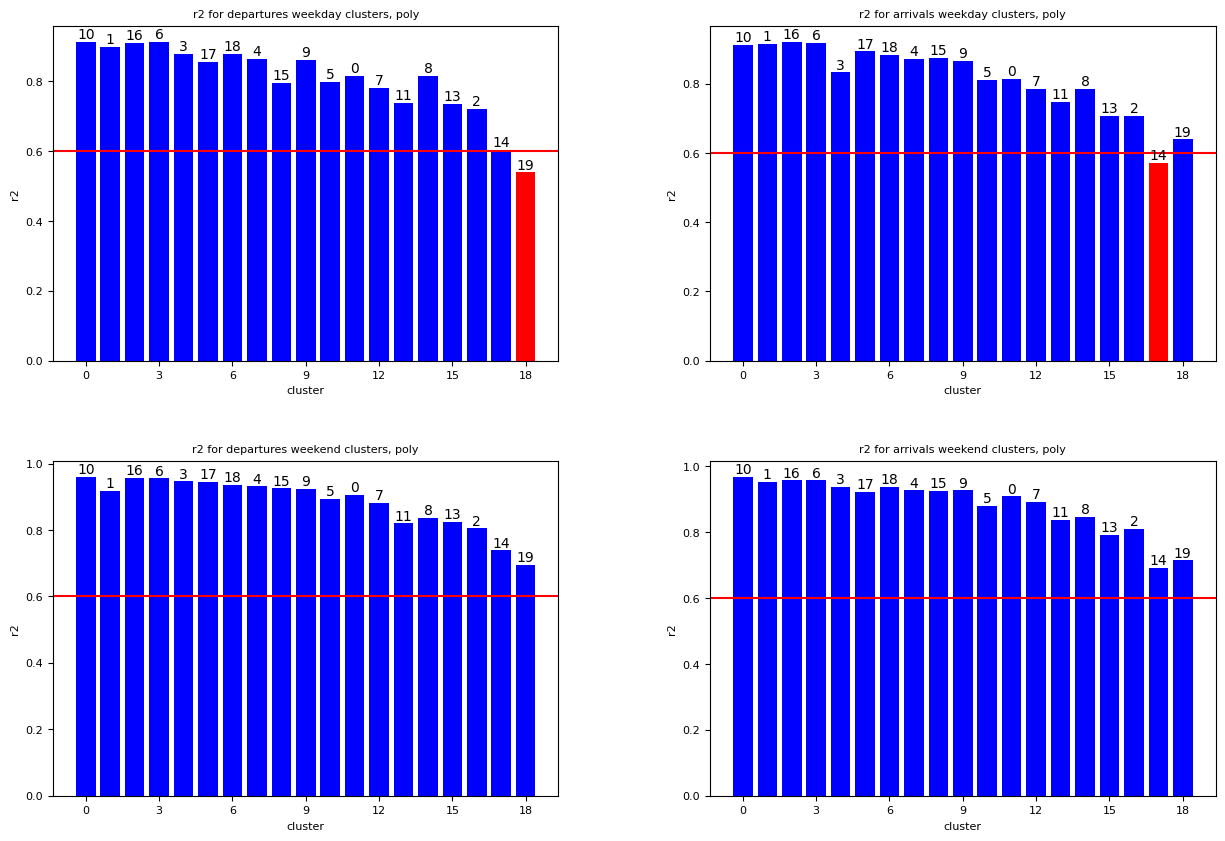

In [624]:
plt.subplot(2, 2, 1)
#put horizontal line at r^2 = 0.6, color the bars that fall below this line red
plt.bar(range(n), [globals()['r2_departures_weekday{}'.format(i)] for i in range(n)], color=['red' if globals()['r2_departures_weekday{}'.format(i)] < 0.6 else 'blue' for i in range(n)])
plt.ylabel('r2')
plt.xlabel('cluster')
plt.title('r2 for departures weekday clusters'+', ' +features)
#put the label of the clusters in each bin in the histogram and center it on the bin, also put it a bit higher so it doesn't overlap with the bar
#reminder that we renamed the largest cluster to 0, so we had to account for this. 
for i in range(n):
    plt.text(i, globals()['r2_departures_weekday{}'.format(i)]+0.01, largest_cluster[i], rotation=0, ha='center')
#increase whitespace between bars
plt.xticks(np.arange(0, n, step=3))
#put horizontal line at r^2 = 0.6
plt.axhline(y=0.6, color='r', linestyle='-')


plt.subplot(2, 2, 2)
#put horizontal line at r^2 = 0.6, color the bars that fall below this line red
plt.bar(range(n), [globals()['r2_arrivals_weekday{}'.format(i)] for i in range(n)], color=['red' if globals()['r2_arrivals_weekday{}'.format(i)] < 0.6 else 'blue' for i in range(n)])
plt.ylabel('r2')
plt.xlabel('cluster')
plt.title('r2 for arrivals weekday clusters'+', ' + features)
#put the label of the clusters in each bin in the histogram and center it on the bin, also put it a bit higher so it doesn't overlap with the bar
#reminder that we renamed the largest cluster to 0, so we had to account for this. 
for i in range(n):
    plt.text(i, globals()['r2_arrivals_weekday{}'.format(i)]+0.01, largest_cluster[i], rotation=0, ha='center')
#increase whitespace between bars
plt.xticks(np.arange(0, n, step=3))
#put horizontal line at r^2 = 0.6
plt.axhline(y=0.6, color='r', linestyle='-')



plt.subplot(2, 2, 3)
#put horizontal line at r^2 = 0.6, color the bars that fall below this line red
plt.bar(range(n), [globals()['r2_departures_weekend{}'.format(i)] for i in range(n)], color=['red' if globals()['r2_departures_weekend{}'.format(i)] < 0.6 else 'blue' for i in range(n)])
plt.ylabel('r2')
plt.xlabel('cluster')
plt.title('r2 for departures weekend clusters'+', ' +features)
#put the label of the clusters in each bin in the histogram and center it on the bin, also put it a bit higher so it doesn't overlap with the bar
#reminder that we renamed the largest cluster to 0, so we had to account for this.
for i in range(n):
    plt.text(i, globals()['r2_departures_weekend{}'.format(i)]+0.01, largest_cluster[i], rotation=0, ha='center')
#increase whitespace between bars
plt.xticks(np.arange(0, n, step=3))
#put horizontal line at r^2 = 0.6
plt.axhline(y=0.6, color='r', linestyle='-')



plt.subplot(2, 2, 4)
#put horizontal line at r^2 = 0.6, color the bars that fall below this line red
plt.bar(range(n), [globals()['r2_arrivals_weekend{}'.format(i)] for i in range(n)], color=['red' if globals()['r2_arrivals_weekend{}'.format(i)] < 0.6 else 'blue' for i in range(n)])
plt.ylabel('r2')
plt.xlabel('cluster')
plt.title('r2 for arrivals weekend clusters'+', ' +features)
#put the label of the clusters in each bin in the histogram and center it on the bin, also put it a bit higher so it doesn't overlap with the bar
#reminder that we renamed the largest cluster to 0, so we had to account for this.
for i in range(n):
    plt.text(i, globals()['r2_arrivals_weekend{}'.format(i)]+0.01, largest_cluster[i], rotation=0, ha='center')
#increase whitespace between bars
plt.xticks(np.arange(0, n, step=3))
#put horizontal line at r^2 = 0.6
plt.axhline(y=0.6, color='r', linestyle='-')

#icrease whitespace between subplots and figure size
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.rcParams["figure.figsize"] = (15,10)

#increase textsizes of title, axes, ticks, labels
plt.rc('axes', titlesize=8)     # fontsize of the axes title
plt.rc('axes', labelsize=8)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=8)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8)    # fontsize of the tick labels
plt.rc('figure', titlesize=8)  # fontsize of the figure title
plt.show()

# #TEMPORARY PLOT: redo plot r2 departures weekend clusters, but with fixed axes from -1 to 1
# plt.bar(range(n), [globals()['r2_departures_weekend{}'.format(i)] for i in range(n)], color=['red' if globals()['r2_departures_weekend{}'.format(i)] < 0.6 else 'blue' for i in range(n)])
# plt.ylabel('r2')
# plt.xlabel('cluster')
# plt.title('TEMPORARY: r2 for departures weekend clusters'+', ' +features)
# #put the label of the clusters in each bin in the histogram and center it on the bin, also put it a bit higher so it doesn't overlap with the bar
# #reminder that we renamed the largest cluster to 0, so we had to account for this.
# for i in range(n):
#     if i == 13:
#         plt.text(i, -0.99, largest_cluster[i], rotation=0, ha='center')
#     else:
#         plt.text(i, globals()['r2_departures_weekend{}'.format(i)]+0.01, largest_cluster[i], rotation=0, ha='center')
# #increase whitespace between bars
# plt.xticks(np.arange(0, n, step=3))
# #put horizontal line at r^2 = 0.6
# plt.axhline(y=0.6, color='r', linestyle='-')
# plt.ylim(-1, 1)
# plt.show()



THe decreasing trend is most likely since we ordered the clusters by largest to smallest amount of datapoints. Hence the clusters to the right have less datapoints to predict on and will thus perform worse. Also, as previously visible in the shape checks, the amount of datapoints they have less is very significant. Additionally, the missing datapoints are dispersed in time rather than showing a regular trend, making it even more detrimental, since this makes it often occurring that you dont have a lagged datapoint at your disposal, or that you use lagged data not from the previous 30 hours, but from the previous 36 (if 6 hours are missing), making predictions worse. 

These are empty because there are no departure data for these therefore no model will be created.

In [138]:
# import XGB regressor
from sklearn.ensemble import RandomForestRegressor as XGBRegressor
from sklearn.linear_model import LinearRegression
# r^2 score
from sklearn.metrics import r2_score




In [303]:


for i in range(n):
    
    if globals()['x_departures_train_{}'.format(i)].empty or globals()['x_arrivals_train_{}'.format(i)].empty:
        print('EMPTY')
        continue
    
    globals()['reg_departures_{}'.format(i)] = XGBRegressor().fit(globals()['x_departures_train_{}'.format(i)], globals()['y_departures_train_{}'.format(i)])
    globals()['reg_arrivals_{}'.format(i)] = XGBRegressor().fit(globals()['x_arrivals_train_{}'.format(i)], globals()['y_arrivals_train_{}'.format(i)])

    # save the results to variables
    globals()['y_departures_pred_{}'.format(i)] = globals()['reg_departures_{}'.format(i)].predict(globals()['x_departures_test_{}'.format(i)])
    globals()['y_arrivals_pred_{}'.format(i)] = globals()['reg_arrivals_{}'.format(i)].predict(globals()['x_arrivals_test_{}'.format(i)])

    # print r^2 score using the y_departures_pred and y_arrivals_pred
    print('r^2 score for departures label {}: {}'.format(largest_cluster[i], r2_score(globals()['y_departures_test_{}'.format(i)], globals()['y_departures_pred_{}'.format(i)])))
    print('r^2 score for arrivals label {}: {}'.format(largest_cluster[i], r2_score(globals()['y_arrivals_test_{}'.format(i)], globals()['y_arrivals_pred_{}'.format(i)])))
    



r^2 score for departures label 8: -103.01063212489892
r^2 score for arrivals label 8: -95.39932994090275
r^2 score for departures label 5: -94.69750716837835
r^2 score for arrivals label 5: -100.04848501354799
r^2 score for departures label 0: -97.58307522010037
r^2 score for arrivals label 0: -88.8312883083732
r^2 score for departures label 9: -76.13222560439797
r^2 score for arrivals label 9: -72.83073576067895
r^2 score for departures label 2: -125.05739209077616
r^2 score for arrivals label 2: -104.8209630901356
r^2 score for departures label 13: -112.18608783820098
r^2 score for arrivals label 13: -96.203305061389
r^2 score for departures label 17: -83.68388925933037
r^2 score for arrivals label 17: -73.11342786634357
r^2 score for departures label 16: -138.99155770360315
r^2 score for arrivals label 16: -147.55776386740877
r^2 score for departures label 19: -105.10795616379909
r^2 score for arrivals label 19: -117.42968143926078
r^2 score for departures label 6: -90.6066012015627

Plotting doesn't work that well

In [251]:

# # plot in grid
# fig, axs = plt.subplots(2, n, figsize=(20,20))
# for i in range(n):
#     if globals()['x_departures_train_{}'.format(i)].empty or globals()['x_arrivals_train_{}'.format(i)].empty:
#         print('EMPTYTTTTTYY')
#         continue
#     axs[0, i].scatter(globals()['x_departures_test_{}'.format(i)][:,0], globals()['y_departures_test_{}'.format(i)], s=0.75)
#     axs[0, i].scatter(globals()['x_departures_test_{}'.format(i)][:,0], globals()['reg_departures_{}'.format(i)].predict(globals()['x_departures_test_{}'.format(i)]), color='red')
#     axs[0, i].set_title('Departures label {}'.format(largest_cluster[i]))
#     axs[0, i].set_ylabel('Count')
#     axs[0, i].set_xlabel('Hour')
#     axs[1, i].scatter(globals()['x_arrivals_test_{}'.format(i)][:,0], globals()['y_arrivals_test_{}'.format(i)], s=0.75)
#     axs[1, i].scatter(globals()['x_arrivals_test_{}'.format(i)][:,0], globals()['reg_arrivals_{}'.format(i)].predict(globals()['x_arrivals_test_{}'.format(i)]), color='red')
#     axs[1, i].set_title('Arrivals label {}'.format(largest_cluster[i]))
#     axs[1, i].set_ylabel('Count')
#     axs[1, i].set_xlabel('Hour')

Add polynomials to increase r^2

In [297]:
# specify the degree of polynomial that aproximates the pickup data
degree = 5

In [304]:

def add_polynomial(x_data, n):
    x_data_poly = x_data.copy()
    for i in range(2, n+1):
        x_data_poly = np.concatenate((x_data_poly, np.power(x_data, i)), axis=1)
    return x_data_poly

In [305]:
print(add_polynomial(x_departures_train_0, degree).shape)

(240, 5)


In [306]:
# add polynomial features
for i in range(n):
    if globals()['x_departures_train_{}'.format(i)].empty or globals()['x_arrivals_train_{}'.format(i)].empty:
        print('EMPTY')
        continue
    globals()['x_departures_train_{}_poly'.format(i)] = add_polynomial(globals()['x_departures_train_{}'.format(i)], degree)
    globals()['x_departures_test_{}_poly'.format(i)] = add_polynomial(globals()['x_departures_test_{}'.format(i)], degree)
    globals()['x_arrivals_train_{}_poly'.format(i)] = add_polynomial(globals()['x_arrivals_train_{}'.format(i)], degree)
    globals()['x_arrivals_test_{}_poly'.format(i)] = add_polynomial(globals()['x_arrivals_test_{}'.format(i)], degree)

# train lin reg model per label with polynomial features

for i in range(n):
    if globals()['x_departures_train_{}'.format(i)].empty or globals()['x_arrivals_train_{}'.format(i)].empty:
        print('EMPTY')
        continue
    globals()['reg_departures_{}_poly'.format(i)] = XGBRegressor().fit(globals()['x_departures_train_{}_poly'.format(i)], globals()['y_departures_train_{}'.format(i)])
    globals()['reg_arrivals_{}_poly'.format(i)] = XGBRegressor().fit(globals()['x_arrivals_train_{}_poly'.format(i)], globals()['y_arrivals_train_{}'.format(i)])

    # print r^2 score
    print('r^2 score for departures label {}: {}'.format(largest_cluster[i], r2_score(globals()['y_departures_test_{}'.format(i)], globals()['reg_departures_{}_poly'.format(i)].predict(globals()['x_departures_test_{}_poly'.format(i)]))))
    print('r^2 score for arrivals label {}: {}'.format(largest_cluster[i], r2_score(globals()['y_arrivals_test_{}'.format(i)], globals()['reg_arrivals_{}_poly'.format(i)].predict(globals()['x_arrivals_test_{}_poly'.format(i)]))))



EMPTY
r^2 score for departures label 8: -103.01129912779624
r^2 score for arrivals label 8: -95.39932994090275
r^2 score for departures label 5: -94.69750716837835
r^2 score for arrivals label 5: -100.04848501354799
r^2 score for departures label 0: -97.58307522010037
r^2 score for arrivals label 0: -88.8312883083732
r^2 score for departures label 9: -76.13222560439797
r^2 score for arrivals label 9: -72.83073576067895
r^2 score for departures label 2: -124.76950954168487
r^2 score for arrivals label 2: -104.8209630901356
r^2 score for departures label 13: -112.18608783820098
r^2 score for arrivals label 13: -96.20794889909237
r^2 score for departures label 17: -83.70151541966715
r^2 score for arrivals label 17: -73.11342786634357
r^2 score for departures label 16: -138.99155770360315
r^2 score for arrivals label 16: -147.55776386740877
r^2 score for departures label 19: -105.10795616379909
r^2 score for arrivals label 19: -117.42968143926078
r^2 score for departures label 6: -90.60660

In [131]:
# plot
# fig, axs = plt.subplots(n, 2, figsize=(20,20))
# for i in range(n):
#     if globals()['x_departures_train_{}'.format(i)].empty or globals()['x_arrivals_train_{}'.format(i)].empty:
#         print('EMPTYYY' + str(largest_cluster[i]))
#         continue
#     axs[i, 0].scatter(globals()['x_departures_test_{}'.format(i)][:,0], globals()['y_departures_test_{}'.format(i)])
#     axs[i, 0].scatter(globals()['x_departures_test_{}'.format(i)][:,0], globals()['reg_departures_{}_poly'.format(i)].predict(globals()['x_departures_test_{}_poly'.format(i)]), color='red')
#     axs[i, 0].set_title('Departures label {}'.format(largest_cluster[i]))
#     axs[i, 0].set_ylabel('Count')
#     axs[i, 0].set_xlabel('Hour')
#     axs[i, 1].scatter(globals()['x_arrivals_test_{}'.format(i)][:,0], globals()['y_arrivals_test_{}'.format(i)])
#     axs[i, 1].scatter(globals()['x_arrivals_test_{}'.format(i)][:,0], globals()['reg_arrivals_{}_poly'.format(i)].predict(globals()['x_arrivals_test_{}_poly'.format(i)]), color='red')
#     axs[i, 1].set_title('Arrivals label {}'.format(largest_cluster[i]))
#     axs[i, 1].set_ylabel('Count')
#     axs[i, 1].set_xlabel('Hour')



Add lag to increase r^2 

In [39]:
# lag features
def add_lag_features(df, n):
    df_lag = df.copy()
    for i in range(1, n+1):
        df_lag['lag_{}'.format(i)] = df_lag['count'].shift(i)
    df_lag.dropna(inplace=True)
    return df_lag

In [40]:
# add 3 lag features
for i in range(n):
    globals()['df_departures_train_{}_lag'.format(i)] = add_lag_features(globals()['df_departures_train_{}'.format(i)], 3)
    globals()['df_departures_test_{}_lag'.format(i)] = add_lag_features(globals()['df_departures_test_{}'.format(i)], 3)
    globals()['df_arrivals_train_{}_lag'.format(i)] = add_lag_features(globals()['df_arrivals_train_{}'.format(i)], 3)
    globals()['df_arrivals_test_{}_lag'.format(i)] = add_lag_features(globals()['df_arrivals_test_{}'.format(i)], 3)

In [41]:
# split x and y data
for i in range(n):
    globals()['x_departures_train_{}_lag'.format(i)], globals()['y_departures_train_{}_lag'.format(i)] = create_x_y(globals()['df_departures_train_{}_lag'.format(i)])
    globals()['x_departures_test_{}_lag'.format(i)], globals()['y_departures_test_{}_lag'.format(i)] = create_x_y(globals()['df_departures_test_{}_lag'.format(i)])
    globals()['x_arrivals_train_{}_lag'.format(i)], globals()['y_arrivals_train_{}_lag'.format(i)] = create_x_y(globals()['df_arrivals_train_{}_lag'.format(i)])
    globals()['x_arrivals_test_{}_lag'.format(i)], globals()['y_arrivals_test_{}_lag'.format(i)] = create_x_y(globals()['df_arrivals_test_{}_lag'.format(i)])

# add poly 6 features
for i in range(n):
    globals()['x_departures_train_{}_lag'.format(i)] = add_polynomial(globals()['x_departures_train_{}_lag'.format(i)], 6)
    globals()['x_departures_test_{}_lag'.format(i)] = add_polynomial(globals()['x_departures_test_{}_lag'.format(i)], 6)
    globals()['x_arrivals_train_{}_lag'.format(i)] = add_polynomial(globals()['x_arrivals_train_{}_lag'.format(i)], 6)
    globals()['x_arrivals_test_{}_lag'.format(i)] = add_polynomial(globals()['x_arrivals_test_{}_lag'.format(i)], 6)

# train lin reg model per label with lag features
for i in range(n):
    globals()['reg_departures_{}_lag'.format(i)] = LinearRegression().fit(globals()['x_departures_train_{}_lag'.format(i)], globals()['y_departures_train_{}_lag'.format(i)])
    globals()['reg_arrivals_{}_lag'.format(i)] = LinearRegression().fit(globals()['x_arrivals_train_{}_lag'.format(i)], globals()['y_arrivals_train_{}_lag'.format(i)])

    # print r^2 score
    print('r^2 score for departures label {}: {}'.format(largest_cluster[i], r2_score(globals()['y_departures_test_{}_lag'.format(i)], globals()['reg_departures_{}_lag'.format(i)].predict(globals()['x_departures_test_{}_lag'.format(i)]))))
    print('r^2 score for arrivals label {}: {}'.format(largest_cluster[i], r2_score(globals()['y_arrivals_test_{}_lag'.format(i)], globals()['reg_arrivals_{}_lag'.format(i)].predict(globals()['x_arrivals_test_{}_lag'.format(i)]))))


In [42]:
# plot
fig, axs = plt.subplots(2, n, figsize=(20,10))
for i in range(n):
    axs[0, i].scatter(globals()['x_departures_test_{}_lag'.format(i)][:,0], globals()['y_departures_test_{}_lag'.format(i)], s=1)
    axs[0, i].scatter(globals()['x_departures_test_{}_lag'.format(i)][:,0], globals()['reg_departures_{}_lag'.format(i)].predict(globals()['x_departures_test_{}_lag'.format(i)]), color='red')
    axs[0, i].set_title('Departures label {}'.format(largest_cluster[i]))
    axs[0, i].set_ylabel('Count')
    axs[0, i].set_xlabel('Hour')
    axs[1, i].scatter(globals()['x_arrivals_test_{}_lag'.format(i)][:,0], globals()['y_arrivals_test_{}_lag'.format(i)], s=1)
    axs[1, i].scatter(globals()['x_arrivals_test_{}_lag'.format(i)][:,0], globals()['reg_arrivals_{}_lag'.format(i)].predict(globals()['x_arrivals_test_{}_lag'.format(i)]), color='red')
    axs[1, i].set_title('Arrivals label {}'.format(largest_cluster[i]))
    axs[1, i].set_ylabel('Count')
    axs[1, i].set_xlabel('Hour')


Lag doesn't really help so shouldn't include

In [43]:
# make random forest model
# from sklearn.ensemble import RandomForestRegressor

# # train random forest model per label with lag features
# for i in range(n):
#     globals()['reg_departures_{}_lag_rf'.format(i)] = RandomForestRegressor().fit(globals()['x_departures_train_{}_lag'.format(i)], globals()['y_departures_train_{}_lag'.format(i)])
#     globals()['reg_arrivals_{}_lag_rf'.format(i)] = RandomForestRegressor().fit(globals()['x_arrivals_train_{}_lag'.format(i)], globals()['y_arrivals_train_{}_lag'.format(i)])

#     # print r^2 score
#     print('r^2 score for departures label {}: {}'.format(largest_cluster[i], r2_score(globals()['y_departures_test_{}_lag'.format(i)], globals()['reg_departures_{}_lag_rf'.format(i)].predict(globals()['x_departures_test_{}_lag'.format(i)]))))
#     print('r^2 score for arrivals label {}: {}'.format(largest_cluster[i], r2_score(globals()['y_arrivals_test_{}_lag'.format(i)], globals()['reg_arrivals_{}_lag_rf'.format(i)].predict(globals()['x_arrivals_test_{}_lag'.format(i)]))))

## Part 3



In [44]:
df = df_copy2.copy()

#do same manipulations on df as done previously for the 5 largest clusters, but this time for all clusters
df_departures = df[['starttime', 'pick_label']].copy()
df_arrivals = df[['stoptime', 'drop_label']].copy()


# rename label columns
df_departures.rename(columns={'pick_label':'label'}, inplace=True)
df_arrivals.rename(columns={'drop_label':'label'}, inplace=True)

# Extract date and time components
def extract_date_time_components(df, time_column):
    df['hour'] = df[time_column].dt.hour
    df['day'] = df[time_column].dt.day
    df['month'] = df[time_column].dt.month
    df.drop(columns=[time_column], inplace=True)

extract_date_time_components(df_departures, 'starttime')
extract_date_time_components(df_arrivals, 'stoptime')

# Remove trip_id index
df_departures.reset_index(drop=True, inplace=True)
df_arrivals.reset_index(drop=True, inplace=True)

# Count the number of rows with the same label, hour, and save it in a new column
def count(df):
    counts = df.groupby(['label', 'hour']).size().reset_index(name='count')
    df = df.merge(counts, on=['label', 'hour'], how='left')
    return df
df_departures = count(df_departures)
df_arrivals = count(df_arrivals)

df_departures_copy = df_departures.copy()
df_arrivals_copy = df_arrivals.copy()

KeyboardInterrupt: 

In [ ]:
#check we have included all clusters
print(np.sort(df_arrivals.label.unique()))
print(np.sort(df_departures.label.unique()))



notice that cluster 12 is the group of red outliers in the map of all end stations, apparently this cluster only has arrivals and no departures. As a consequence, no bikes have to be moved to stations within this cluster, and the cluster can be ignored for this section. 

In [ ]:
df_departures = df_departures[df_departures['label'] != 12]
df_arrivals = df_arrivals[df_arrivals['label'] != 12]
print(np.sort(df_arrivals.label.unique()))
print(np.sort(df_departures.label.unique()))

Similarly to the method presented in the previous section, we will train prediction models to predict he change in arrivals and departures over the course of time. This time, however, models for all the relevant clusters will have to be trained. The method will be similar however. 

In [ ]:
# include all relevant clusters
n = 19

# redifine largest cluster
largest_cluster = df['pick_label'].value_counts().nlargest(n).index[:n]
print(largest_cluster)

# split data
df_departures_train, df_departures_test = split_train_test(df_departures)
df_arrivals_train, df_arrivals_test = split_train_test(df_arrivals)

# split data per label for n
for i in range(n):
    globals()['df_departures_train_{}'.format(i)] = df_departures_train[df_departures_train['label'] == largest_cluster[i]]
    globals()['df_departures_test_{}'.format(i)] = df_departures_test[df_departures_test['label'] == largest_cluster[i]]
    globals()['df_arrivals_train_{}'.format(i)] = df_arrivals_train[df_arrivals_train['label'] == largest_cluster[i]]
    globals()['df_arrivals_test_{}'.format(i)] = df_arrivals_test[df_arrivals_test['label'] == largest_cluster[i]]

    # split x and y 
    globals()['x_departures_train_{}'.format(i)], globals()['y_departures_train_{}'.format(i)] = create_x_y(globals()['df_departures_train_{}'.format(i)])
    globals()['x_departures_test_{}'.format(i)], globals()['y_departures_test_{}'.format(i)] = create_x_y(globals()['df_departures_test_{}'.format(i)])
    globals()['x_arrivals_train_{}'.format(i)], globals()['y_arrivals_train_{}'.format(i)] = create_x_y(globals()['df_arrivals_train_{}'.format(i)])
    globals()['x_arrivals_test_{}'.format(i)], globals()['y_arrivals_test_{}'.format(i)] = create_x_y(globals()['df_arrivals_test_{}'.format(i)])

In [ ]:
# add polynomial features
n_poly = 10
for i in range(n):
    globals()['x_departures_train_{}_poly'.format(i)] = add_polynomial(globals()['x_departures_train_{}'.format(i)], n_poly)
    globals()['x_departures_test_{}_poly'.format(i)] = add_polynomial(globals()['x_departures_test_{}'.format(i)], n_poly)
    globals()['x_arrivals_train_{}_poly'.format(i)] = add_polynomial(globals()['x_arrivals_train_{}'.format(i)], n_poly)
    globals()['x_arrivals_test_{}_poly'.format(i)] = add_polynomial(globals()['x_arrivals_test_{}'.format(i)], n_poly)

# train lin reg model per label with polynomial features
for i in range(n):
    globals()['reg_departures_{}_poly'.format(i)] = LinearRegression().fit(globals()['x_departures_train_{}_poly'.format(i)], globals()['y_departures_train_{}'.format(i)])
    globals()['reg_arrivals_{}_poly'.format(i)] = LinearRegression().fit(globals()['x_arrivals_train_{}_poly'.format(i)], globals()['y_arrivals_train_{}'.format(i)])

    # print r^2 score
    print('r^2 score for departures label {}: {}'.format(largest_cluster[i], r2_score(globals()['y_departures_test_{}'.format(i)], globals()['reg_departures_{}_poly'.format(i)].predict(globals()['x_departures_test_{}_poly'.format(i)]))))
    print('r^2 score for arrivals label {}: {}'.format(largest_cluster[i], r2_score(globals()['y_arrivals_test_{}'.format(i)], globals()['reg_arrivals_{}_poly'.format(i)].predict(globals()['x_arrivals_test_{}_poly'.format(i)]))))

In [ ]:
#create a dataframe with new data from january 2019 to variable month, take march 2019 for now, for predicions in the future. 
df_arrivals_future = df_arrivals_copy.copy()
df_departures_future = df_departures_copy.copy()

#remove cluster 12 for same reasons as before
df_arrivals_future = df_arrivals_future[df_arrivals_future['label'] != 12]
df_departures_future = df_departures_future[df_departures_future['label'] != 12]
print(np.sort(df_arrivals_future.label.unique()))
print(np.sort(df_departures_future.label.unique()))

# define amount of months you want to look ahead from jan 2019. 
month_end = 3
df_arrivals_future = df_arrivals_future[df_arrivals_future['month'] <= month_end]
df_departures_future = df_departures_future[df_departures_future['month'] <= month_end]

#get rid of the counts column for the future data, as we will be predicting this
df_arrivals_future.drop(columns=['count'], inplace=True)
df_departures_future.drop(columns=['count'], inplace=True)

#get rid of month column as it is not needed (similarly as before)
df_arrivals_future.drop(columns=['month'], inplace=True)
df_departures_future.drop(columns=['month'], inplace=True)

# split data per label for n
for i in range(n):
    globals()['df_departures_future_{}'.format(i)] = df_departures_future[df_departures_future['label'] == largest_cluster[i]]
    globals()['df_arrivals_future_{}'.format(i)] = df_arrivals_future[df_arrivals_future['label'] == largest_cluster[i]]

#add as many polynomial features as we did for the training data
for i in range(n):
    globals()['df_departures_future_{}_poly'.format(i)] = add_polynomial(globals()['df_departures_future_{}'.format(i)], n_poly)
    globals()['df_arrivals_future_{}_poly'.format(i)] = add_polynomial(globals()['df_arrivals_future_{}'.format(i)], n_poly)


In [ ]:
# predict future data
for i in range(n):
    globals()['df_departures_future_{}_poly'.format(i)]['count'] = globals()['reg_departures_{}_poly'.format(i)].predict(globals()['df_departures_future_{}_poly'.format(i)])
    globals()['df_arrivals_future_{}_poly'.format(i)]['count'] = globals()['reg_arrivals_{}_poly'.format(i)].predict(globals()['df_arrivals_future_{}_poly'.format(i)])

# compute the difference between the predicted arrivals and the predicted departures for each cluster per hour and store in new dataframe
for i in range(n):
    globals()['df_arrivals_future_{}_poly'.format(i)]['difference'] = globals()['df_arrivals_future_{}_poly'.format(i)]['count'] - globals()['df_departures_future_{}_poly'.format(i)]['count']

# sum the differences per hour for a specific cluster per day
for i in range(n):
    globals()['df_arrivals_future_{}_poly'.format(i)] = globals()['df_arrivals_future_{}_poly'.format(i)].groupby(['label', 'day']).sum().reset_index()

# print per day for a specific cluster the difference between predicted arrivals and predicted departures
for i in range(n):
    print(globals()['df_arrivals_future_{}_poly'.format(i)].head())
    

# sum 

In [ ]:
# if we ever want to predict for multiple years ahead, we can use this, but then we also need to include the year in our model to distinguish between the inputs
# month_end = 3
# if month_end > 12:
#     years = month_end // 12
#     month_end = month_end % 12
# for i in range(years):
#     df_arrivals_future = df_arrivals_future.append(df_arrivals_copy)
#     df_departures_future = df_departures_future.append(df_departures_copy)

# df_arrivals_future = df_arrivals_future.append(df_arrivals_copy[['month'] <= month_end])
# df_departures_future = df_departures_future.append(df_departures_copy[['month'] <= month_end])

## Exploratory part 

1) What is your research question?
    - Can the addition of NY daily weather data in combination with a  increase prediction accuracy?

<br>

2) Which data are you planning to use and from where are you planning to get it?
    - We will use both the trips_2018.csv file provided by the course instructors and a self-gathered dataset containing the 2018 daily weather data in NYC, with the assumption that the weather at Central Park is representative of the weather in the entire spatial scope of the bike stations included in the dataset. A link to the data can be found [here](https://www.weather.gov/wrh/climate?wfo=okx)

<br>

3) Which methods are you planning to use?
    - We will attempt to use multiple Neural Networks, the final choice being the best performing one. 

<br>

4) Which benchmark are you going to use? 
    - The benchmark will be the performance of the prediction model introduced in Part 2 of the mandatory assignment. 

<br>

5) Which metrics and methods are you planning for validation? 
    - The R^2 value of the predictions. 

In [39]:
#clear all variables for memory overflow reasons
%reset -f

# #reset python kernel
# import IPython
# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)


#import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# redefine all variables you actually need. from scratch. This follows the same code as before, so can be negected. 
df = pd.read_csv('data/Trips_2018.csv')
df.rename(columns={'Unnamed: 0':'trip_id'}, inplace=True)
df.set_index('trip_id', inplace=True)
df['starttime'] = pd.to_datetime(df['starttime'], format="%Y-%m-%d %H:%M:%S.%f")
df['stoptime'] = pd.to_datetime(df['stoptime'], format="%Y-%m-%d %H:%M:%S.%f")
df = pd.get_dummies(df, columns=['usertype'], dtype=int, drop_first=True)
coords = df[['start_station_longitude','start_station_latitude']].values
coords = np.unique(coords, axis=0)
coords = coords[coords[:,0] < -73.6]
df = df[~np.isnan(df['start_station_id'])]
df = df[~np.isnan(df['end_station_id'])]
df = df[df['start_station_longitude'] < -73.6]
df = df[df['end_station_longitude'] < -73.6]
coords_start = df[['start_station_longitude','start_station_latitude']].values
coords_start = np.unique(coords_start, axis=0)
coords_start_copy = coords_start.copy()
coords_end = df[['end_station_longitude','end_station_latitude']].values
coords_end = np.unique(coords_end, axis=0)
n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(coords_end)
df['drop_label'] = kmeans.predict(df[['end_station_longitude','end_station_latitude']].values)
df['pick_label'] = kmeans.predict(df[['start_station_longitude','start_station_latitude']].values)



/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [40]:
#split dataframe
df_departures = df[['starttime', 'pick_label']].copy()
df_arrivals = df[['stoptime', 'drop_label']].copy()

In [41]:
#split starttime into date y-m-d and time h-m-s
df_departures['Date'] = df_departures['starttime'].dt.date
df_departures['Time'] = df_departures['starttime'].dt.time
df_arrivals['Date'] = df_arrivals['stoptime'].dt.date
df_arrivals['Time'] = df_arrivals['stoptime'].dt.time

#drop starttime and stoptime columns
df_departures.drop(columns=['starttime'], inplace=True)
df_arrivals.drop(columns=['stoptime'], inplace=True)

#convert date to datetime object
df_departures['Date'] = pd.to_datetime(df_departures['Date'], format="%Y-%m-%d")
df_arrivals['Date'] = pd.to_datetime(df_arrivals['Date'], format="%Y-%m-%d")


In [43]:
#open weather data 2018, read textfile and convert to dataframe
text = open('data/2018_weather_data.txt', 'r')
weather_data = text.read()
weather_data = weather_data.split('\n')
weather_data = [i.split('\t') for i in weather_data[1:]]
print(weather_data)
weather_data = pd.DataFrame(weather_data)
weather_data.columns = ['Date', 'Max_temp', 'Min_temp', 'Avg_temp', 'Departure_temp', 'HDD', 'CDD', 'Precipitation', 'Snowfall', 'Snow_depth']
weather_data.head()

#change date column to datetime object
weather_data['Date'] = pd.to_datetime(weather_data['Date'], format="%Y-%m-%d")
weather_data.head()


[['2018-01-01', '19', '7', '13.0', '-22.2', '52', '0', '0.00', '0.0', 'T'], ['2018-01-02', '26', '13', '19.5', '-15.5', '45', '0', '0.00', '0.0', '0'], ['2018-01-03', '30', '16', '23.0', '-11.8', '42', '0', '0.00', '0.0', 'T'], ['2018-01-04', '29', '19', '24.0', '-10.7', '41', '0', '0.76', '9.8', '1'], ['2018-01-05', '19', '9', '14.0', '-20.5', '51', '0', '0.00', '0.0', '7'], ['2018-01-06', '13', '6', '9.5', '-24.9', '55', '0', '0.00', '0.0', '6'], ['2018-01-07', '18', '5', '11.5', '-22.7', '53', '0', '0.00', '0.0', '6'], ['2018-01-08', '31', '17', '24.0', '-10.1', '41', '0', '0.01', 'T', '5'], ['2018-01-09', '44', '30', '37.0', '3.1', '28', '0', '0.00', '0.0', '5'], ['2018-01-10', '43', '30', '36.5', '2.7', '28', '0', '0.00', '0.0', '4'], ['2018-01-11', '53', '41', '47.0', '13.3', '18', '0', '0.00', '0.0', '3'], ['2018-01-12', '61', '44', '52.5', '18.9', '12', '0', '0.54', '0.0', 'T'], ['2018-01-13', '58', '19', '38.5', '5.0', '26', '0', '0.05', '0.0', '0'], ['2018-01-14', '25', '15',

,Date,Max_temp,Min_temp,Avg_temp,Departure_temp,HDD,CDD,Precipitation,Snowfall,Snow_depth
0,2018-01-01,19,7,13.0,-22.2,52,0,0.00,0.0,T
1,2018-01-02,26,13,19.5,-15.5,45,0,0.00,0.0,0
2,2018-01-03,30,16,23.0,-11.8,42,0,0.00,0.0,T
3,2018-01-04,29,19,24.0,-10.7,41,0,0.76,9.8,1
4,2018-01-05,19,9,14.0,-20.5,51,0,0.00,0.0,7


In [44]:
df_departures.head()

,pick_label,Date,Time
trip_id,,,
0,1,2018-01-01,13:50:57.434000
1,1,2018-01-01,15:33:30.182000
2,1,2018-01-01,15:39:18.337000
3,1,2018-01-01,15:40:13.372000
4,1,2018-01-01,18:14:51.568000


In [45]:
#merge weather data with our dataframe based on date
df_departures = df_departures.merge(weather_data, left_on='Date', right_on='Date', how='left')
df_arrivals = df_arrivals.merge(weather_data, left_on='Date', right_on='Date', how='left')

In [46]:
df_departures.head()

,pick_label,Date,Time,Max_temp,Min_temp,Avg_temp,Departure_temp,HDD,CDD,Precipitation,Snowfall,Snow_depth
0,1,2018-01-01,13:50:57.434000,19,7,13.0,-22.2,52,0,0.00,0.0,T
1,1,2018-01-01,15:33:30.182000,19,7,13.0,-22.2,52,0,0.00,0.0,T
2,1,2018-01-01,15:39:18.337000,19,7,13.0,-22.2,52,0,0.00,0.0,T
3,1,2018-01-01,15:40:13.372000,19,7,13.0,-22.2,52,0,0.00,0.0,T
4,1,2018-01-01,18:14:51.568000,19,7,13.0,-22.2,52,0,0.00,0.0,T


In [47]:
df_arrivals.head()

,drop_label,Date,Time,Max_temp,Min_temp,Avg_temp,Departure_temp,HDD,CDD,Precipitation,Snowfall,Snow_depth
0,1,2018-01-01,14:07:08.186000,19,7,13.0,-22.2,52,0,0.00,0.0,T
1,1,2018-01-01,15:45:33.341000,19,7,13.0,-22.2,52,0,0.00,0.0,T
2,1,2018-01-01,15:47:35.172000,19,7,13.0,-22.2,52,0,0.00,0.0,T
3,1,2018-01-01,15:45:20.191000,19,7,13.0,-22.2,52,0,0.00,0.0,T
4,15,2018-01-01,18:19:57.642000,19,7,13.0,-22.2,52,0,0.00,0.0,T


In [48]:
# sort data based on date and time
# df_departures.sort_values(by=['Date', 'Time'], inplace=True)
# df_arrivals.sort_values(by=['Date', 'Time'], inplace=True)
# not necessary

#add month of each data entry in new column
df_departures['month'] = df_departures['Date'].dt.month
df_arrivals['month'] = df_arrivals['Date'].dt.month

In [49]:
df_departures.head()

,pick_label,Date,Time,Max_temp,Min_temp,Avg_temp,Departure_temp,HDD,CDD,Precipitation,Snowfall,Snow_depth,month
0,1,2018-01-01,13:50:57.434000,19,7,13.0,-22.2,52,0,0.00,0.0,T,1
1,1,2018-01-01,15:33:30.182000,19,7,13.0,-22.2,52,0,0.00,0.0,T,1
2,1,2018-01-01,15:39:18.337000,19,7,13.0,-22.2,52,0,0.00,0.0,T,1
3,1,2018-01-01,15:40:13.372000,19,7,13.0,-22.2,52,0,0.00,0.0,T,1
4,1,2018-01-01,18:14:51.568000,19,7,13.0,-22.2,52,0,0.00,0.0,T,1


In [50]:
#create new column with the hour of the day
df_departures['hour'] = df_departures['Time'].apply(lambda x: x.hour)
df_arrivals['hour'] = df_arrivals['Time'].apply(lambda x: x.hour)

#create a new column with the day since the start of the year
df_departures['day'] = df_departures['Date'].apply(lambda x: x.dayofyear)
df_arrivals['day'] = df_arrivals['Date'].apply(lambda x: x.dayofyear)

#drop time columns
df_departures.drop(columns=['Time'], inplace=True)
df_arrivals.drop(columns=['Time'], inplace=True)

#get rid of index as it has no real meaning. 
df_departures.reset_index(drop=True, inplace=True)
df_arrivals.reset_index(drop=True, inplace=True)

In [12]:
df_departures.head()
print(df_departures.shape)


(17545760, 14)


In [51]:
#group data per hour and sum the counts, add new column with the sum
counts = df_departures.groupby(['hour', 'day', 'pick_label']).size().reset_index(name='count')
df_departures = df_departures.merge(counts, on=['hour', 'day', 'pick_label'], how='left')
counts = df_arrivals.groupby(['hour', 'day', 'drop_label']).size().reset_index(name='count')
df_arrivals = df_arrivals.merge(counts, on=['hour', 'day', 'drop_label'], how='left')



In [52]:
df_departures.head()

,pick_label,Date,Max_temp,Min_temp,Avg_temp,Departure_temp,HDD,CDD,Precipitation,Snowfall,Snow_depth,month,hour,day,count
0,1,2018-01-01,19,7,13.0,-22.2,52,0,0.00,0.0,T,1,13,1,40
1,1,2018-01-01,19,7,13.0,-22.2,52,0,0.00,0.0,T,1,15,1,52
2,1,2018-01-01,19,7,13.0,-22.2,52,0,0.00,0.0,T,1,15,1,52
3,1,2018-01-01,19,7,13.0,-22.2,52,0,0.00,0.0,T,1,15,1,52
4,1,2018-01-01,19,7,13.0,-22.2,52,0,0.00,0.0,T,1,18,1,44


In [53]:
df_arrivals.head()

,drop_label,Date,Max_temp,Min_temp,Avg_temp,Departure_temp,HDD,CDD,Precipitation,Snowfall,Snow_depth,month,hour,day,count
0,1,2018-01-01,19,7,13.0,-22.2,52,0,0.00,0.0,T,1,14,1,28
1,1,2018-01-01,19,7,13.0,-22.2,52,0,0.00,0.0,T,1,15,1,53
2,1,2018-01-01,19,7,13.0,-22.2,52,0,0.00,0.0,T,1,15,1,53
3,1,2018-01-01,19,7,13.0,-22.2,52,0,0.00,0.0,T,1,15,1,53
4,15,2018-01-01,19,7,13.0,-22.2,52,0,0.00,0.0,T,1,18,1,24


In [54]:
# Get rid of duplicates (ghosts of grouby function, no clue where they come from)
df_departures.drop_duplicates(inplace=True)
df_arrivals.drop_duplicates(inplace=True)

In [55]:
# Do some sanity checks: 
print("Shape of dataset: ",df_departures.shape)
print("Number of unique days: ",len(df_departures['Date'].unique()))
print("Number of unique hours: ",len(df_departures['hour'].unique()))
print("Number of unique labels: ",len(df_departures['pick_label'].unique()))
print("Expected shape after grouping =", 24*365*19, ". Assuming that cluster 12 was removed as argued previously (only contained sations where arrivals were clocked but no departures).")

Shape of dataset:  (160702, 15)
Number of unique days:  365
Number of unique hours:  24
Number of unique labels:  19
Expected shape after grouping = 166440 . Assuming that cluster 12 was removed as argued previously (only contained sations where arrivals were clocked but no departures).


In [56]:
df_departures.head()

,pick_label,Date,Max_temp,Min_temp,Avg_temp,Departure_temp,HDD,CDD,Precipitation,Snowfall,Snow_depth,month,hour,day,count
0,1,2018-01-01,19,7,13.0,-22.2,52,0,0.00,0.0,T,1,13,1,40
1,1,2018-01-01,19,7,13.0,-22.2,52,0,0.00,0.0,T,1,15,1,52
4,1,2018-01-01,19,7,13.0,-22.2,52,0,0.00,0.0,T,1,18,1,44
5,1,2018-01-01,19,7,13.0,-22.2,52,0,0.00,0.0,T,1,21,1,27
6,1,2018-01-02,26,13,19.5,-15.5,45,0,0.00,0.0,0,1,7,2,253


There are entries with T and M in our weather data. What do these mean?
- T - This means that only a trace of precipitation has fallen.  Trace is defined as less than the smallest measurable amount.  That threshold is below for the different precipitation measurements:
    - Liquid precipitation (rain, showers) - Less than 0.005 inches
    - Snowfall - Less than 0.05 inches
    - Snow depth on the ground - Less than 0.5 inches
- M - Means that the data is missing.  This can happen for a variety of reasons including the data did not make a quality check, there was an equipment outage, or even the observer was not available at a manual station

In [57]:
#these are thus not usefull, so replace all T or M entries with 0
df_departures.replace('T', 0, inplace=True)
df_departures.replace('M', 0, inplace=True)
df_arrivals.replace('T', 0, inplace=True)
df_arrivals.replace('M', 0, inplace=True)


In [62]:
#print correlation matrix to see if there are any strong correlations between counts and other features
df_departures.corr().style.background_gradient(cmap='coolwarm')



,pick_label,Date,Max_temp,Min_temp,Avg_temp,Departure_temp,HDD,CDD,Precipitation,Snowfall,Snow_depth,month,hour,day,count
pick_label,1.000000,0.001876,0.002477,0.002653,0.002589,0.001054,-0.002675,0.001725,-0.001068,-0.000492,-0.000812,0.001862,0.002519,0.001876,-0.041522
Date,0.001876,1.000000,0.192560,0.289506,0.242113,-0.023071,-0.258935,0.141953,0.074444,-0.095584,-0.214846,0.996446,-0.014725,1.000000,0.079331
Max_temp,0.002477,0.192560,1.000000,0.959724,0.990446,0.512574,-0.954848,0.803159,0.035500,-0.166895,-0.269148,0.195989,-0.019723,0.192560,0.205276
Min_temp,0.002653,0.289506,0.959724,1.000000,0.989297,0.449545,-0.952808,0.804401,0.059951,-0.154601,-0.268308,0.292122,-0.021189,0.289506,0.200594
Avg_temp,0.002589,0.242113,0.990446,0.989297,1.000000,0.486873,-0.963601,0.811973,0.047865,-0.162566,-0.271485,0.245178,-0.020644,0.242113,0.205075
Departure_temp,0.001054,-0.023071,0.512574,0.449545,0.486873,1.000000,-0.480793,0.369959,0.034661,-0.139767,-0.199785,-0.023845,-0.006364,-0.023071,0.073148
HDD,-0.002675,-0.258935,-0.954848,-0.952808,-0.963601,-0.480793,1.000000,-0.626761,-0.057953,0.182373,0.307027,-0.258998,0.020811,-0.258935,-0.208681
CDD,0.001725,0.141953,0.803159,0.804401,0.811973,0.369959,-0.626761,1.000000,0.008997,-0.080036,-0.122393,0.150640,-0.014691,0.141953,0.142903
Precipitation,-0.001068,0.074444,0.035500,0.059951,0.047865,0.034661,-0.057953,0.008997,1.000000,0.201630,-0.040988,0.074807,0.001346,0.074444,-0.078362
Snowfall,-0.000492,-0.095584,-0.166895,-0.154601,-0.162566,-0.139767,0.182373,-0.080036,0.201630,1.000000,0.127119,-0.090747,-0.012575,-0.095584,-0.058329


In [63]:
df_arrivals.corr().style.background_gradient(cmap='coolwarm')


,drop_label,Date,Max_temp,Min_temp,Avg_temp,Departure_temp,HDD,CDD,Precipitation,Snowfall,Snow_depth,month,hour,day,count
drop_label,1.000000,0.000739,0.001682,0.001691,0.001704,0.000424,-0.001616,0.001460,-0.001129,-0.000190,-0.000812,0.000791,0.001032,0.000761,-0.043939
Date,0.000739,1.000000,0.193123,0.290205,0.242749,-0.022341,-0.259592,0.142289,0.075079,-0.095474,-0.214988,0.994616,-0.013832,0.998040,0.078496
Max_temp,0.001682,0.193123,1.000000,0.959706,0.990442,0.512821,-0.954851,0.802979,0.035236,-0.166929,-0.269641,0.196556,-0.019243,0.193123,0.202620
Min_temp,0.001691,0.290205,0.959706,1.000000,0.989293,0.449565,-0.952804,0.804238,0.059737,-0.154543,-0.268760,0.292822,-0.020546,0.290205,0.198025
Avg_temp,0.001704,0.242749,0.990442,0.989293,1.000000,0.487013,-0.963605,0.811803,0.047623,-0.162555,-0.271964,0.245816,-0.020079,0.242749,0.202435
Departure_temp,0.000424,-0.022341,0.512821,0.449565,0.487013,1.000000,-0.481068,0.369667,0.033875,-0.139504,-0.200490,-0.023135,-0.007588,-0.022341,0.071989
HDD,-0.001616,-0.259592,-0.954851,-0.952804,-0.963605,-0.481068,1.000000,-0.626545,-0.057798,0.182247,0.307619,-0.259657,0.020513,-0.259592,-0.205914
CDD,0.001460,0.142289,0.802979,0.804238,0.811803,0.369667,-0.626545,1.000000,0.008605,-0.080242,-0.122389,0.150984,-0.013691,0.142289,0.141198
Precipitation,-0.001129,0.075079,0.035236,0.059737,0.047623,0.033875,-0.057798,0.008605,1.000000,0.202506,-0.041291,0.075403,0.001596,0.075079,-0.077160
Snowfall,-0.000190,-0.095474,-0.166929,-0.154543,-0.162555,-0.139504,0.182247,-0.080242,0.202506,1.000000,0.125500,-0.090736,-0.010935,-0.095474,-0.057738


We see that only max_temp, min_temp, avg_temp, CDD and hour have strong correlation with counts. This gives reason to believe that we should only account for those features as predictors in our model. 

In [21]:
#create Neural network using keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from sklearn.metrics import r2_score

#import split train val test
from sklearn.model_selection import train_test_split

# #how to split train and test
# def split_train_test(df):
#     df_train = df[df['month'] < 11]
#     df_test = df[df['month'] >= 11]
#     return df_train, df_test

# #split data into train and test set
# df_departures_train, df_departures_test = split_train_test(df_departures)
# df_arrivals_train, df_arrivals_test = split_train_test(df_arrivals)

# split data into train, val and test set
df_departures_train, df_departures_test = train_test_split(df_departures, test_size=0.2)
df_departures_train, df_departures_val = train_test_split(df_departures_train, test_size=0.2)
df_arrivals_train, df_arrivals_test = train_test_split(df_arrivals, test_size=0.2)
df_arrivals_train, df_arrivals_val = train_test_split(df_arrivals_train, test_size=0.2)


# # Now that we have obtained the count, drop month and day since we have a date column. Try the alternative (delete date column) as well to see which one works better. 
# # We only needed these for the groupby function. 
# df_departures.drop(columns=['month', 'day'], inplace=True)
# df_arrivals.drop(columns=['month', 'day'], inplace=True)


#split data into x and y
x_departures_train = df_departures_train[['hour', 'day']].values
x_departures_train = np.asarray(x_departures_train).astype(np.float32)
x_departures_val = df_departures_val[['hour', 'day']].values
x_departures_val = np.asarray(x_departures_val).astype(np.float32)
x_departures_test = df_departures_test[['hour', 'day']].values
x_departures_test = np.asarray(x_departures_test).astype(np.float32)
y_departures_train = df_departures_train['count'].values
y_departures_train = np.asarray(y_departures_train).astype(np.float32)
y_departures_val = df_departures_val['count'].values
y_departures_val = np.asarray(y_departures_val).astype(np.float32)
y_departures_test = df_departures_test['count'].values
y_departures_test = np.asarray(y_departures_test).astype(np.float32)
x_arrivals_train = df_arrivals_train[['hour', 'day']].values
x_arrivals_train = np.asarray(x_arrivals_train).astype(np.float32)
x_arrivals_val = df_arrivals_val[['hour', 'day']].values
x_arrivals_val = np.asarray(x_arrivals_val).astype(np.float32)
x_arrivals_test = df_arrivals_test[['hour', 'day']].values
x_arrivals_test = np.asarray(x_arrivals_test).astype(np.float32)
y_arrivals_train = df_arrivals_train['count'].values
y_arrivals_train = np.asarray(y_arrivals_train).astype(np.float32)
y_arrivals_val = df_arrivals_val['count'].values
y_arrivals_val = np.asarray(y_arrivals_val).astype(np.float32)
y_arrivals_test = df_arrivals_test['count'].values
y_arrivals_test = np.asarray(y_arrivals_test).astype(np.float32)

#standerdize data
x_departures_train[:,0] = (x_departures_train[:,0] - np.mean(x_departures_train[:,0])) / np.std(x_departures_train[:,0])
x_departures_train[:,1] = (x_departures_train[:,1] - np.mean(x_departures_train[:,1])) / np.std(x_departures_train[:,1])
x_departures_val[:,0] = (x_departures_val[:,0] - np.mean(x_departures_val[:,0])) / np.std(x_departures_val[:,0])
x_departures_val[:,1] = (x_departures_val[:,1] - np.mean(x_departures_val[:,1])) / np.std(x_departures_val[:,1])
x_departures_test[:,0] = (x_departures_test[:,0] - np.mean(x_departures_test[:,0])) / np.std(x_departures_test[:,0])
x_departures_test[:,1] = (x_departures_test[:,1] - np.mean(x_departures_test[:,1])) / np.std(x_departures_test[:,1])
x_arrivals_train[:,0] = (x_arrivals_train[:,0] - np.mean(x_arrivals_train[:,0])) / np.std(x_arrivals_train[:,0])
x_arrivals_train[:,1] = (x_arrivals_train[:,1] - np.mean(x_arrivals_train[:,1])) / np.std(x_arrivals_train[:,1])
x_arrivals_val[:,0] = (x_arrivals_val[:,0] - np.mean(x_arrivals_val[:,0])) / np.std(x_arrivals_val[:,0])
x_arrivals_val[:,1] = (x_arrivals_val[:,1] - np.mean(x_arrivals_val[:,1])) / np.std(x_arrivals_val[:,1])
x_arrivals_test[:,0] = (x_arrivals_test[:,0] - np.mean(x_arrivals_test[:,0])) / np.std(x_arrivals_test[:,0])
x_arrivals_test[:,1] = (x_arrivals_test[:,1] - np.mean(x_arrivals_test[:,1])) / np.std(x_arrivals_test[:,1])

y_departures_train = (y_departures_train - np.mean(y_departures_train)) / np.std(y_departures_train)
y_departures_val = (y_departures_val - np.mean(y_departures_val)) / np.std(y_departures_val)
y_departures_test = (y_departures_test - np.mean(y_departures_test)) / np.std(y_departures_test)
y_arrivals_train = (y_arrivals_train - np.mean(y_arrivals_train)) / np.std(y_arrivals_train)
y_arrivals_val = (y_arrivals_val - np.mean(y_arrivals_val)) / np.std(y_arrivals_val)
y_arrivals_test = (y_arrivals_test - np.mean(y_arrivals_test)) / np.std(y_arrivals_test)

#Train neural network
model_departures = Sequential()
model_departures.add(Dense(1000, activation='relu', input_dim=2))
model_departures.add(Dropout(0.5))
model_departures.add(Dense(1000, activation='relu'))
model_departures.add(Dropout(0.5))
model_departures.add(Dense(1, activation='relu'))

model_departures.compile(loss='mean_squared_error',
                         optimizer='adam',
                         metrics=['accuracy'])

# model_departures.fit(x_departures_train, y_departures_train,
#                      epochs=20,
#                      batch_size=128)
model_departures.fit(x_departures_train, y_departures_train,
                        epochs=20,
                        batch_size=128,
                        validation_data=(x_departures_val, y_departures_val))

#Train neural network
model_arrivals = Sequential()
model_arrivals.add(Dense(1000, activation='relu', input_dim=2))
model_arrivals.add(Dropout(0.5))
model_arrivals.add(Dense(1000, activation='relu'))
model_arrivals.add(Dropout(0.5))
model_arrivals.add(Dense(1, activation='relu'))

model_arrivals.compile(loss='mean_squared_error',
                       optimizer='adam',
                       metrics=['accuracy'])

# model_arrivals.fit(x_arrivals_train, y_arrivals_train, 
#                    epochs=20,
#                    batch_size=128)
model_arrivals.fit(x_arrivals_train, y_arrivals_train, 
                    epochs=20,
                    batch_size=128,
                    validation_data=(x_arrivals_val, y_arrivals_val))

#predict data
y_departures_pred = model_departures.predict(x_departures_test)
y_arrivals_pred = model_arrivals.predict(x_arrivals_test)

#plot data
plt.scatter(y_departures_test, y_departures_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

#plot data
plt.scatter(y_arrivals_test, y_arrivals_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

#print r^2 score
print('r^2 score for departures: {}'.format(r2_score(y_departures_test, y_departures_pred)))
print('r^2 score for arrivals: {}'.format(r2_score(y_arrivals_test, y_arrivals_pred)))


Epoch 1/20
804/804 [==============================] - 16s 19ms/step - loss: 1.0001 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 2/20
804/804 [==============================] - 19s 23ms/step - loss: 1.0000 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 3/20
804/804 [==============================] - 17s 22ms/step - loss: 0.9999 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 4/20
804/804 [==============================] - 17s 21ms/step - loss: 1.0000 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 5/20
804/804 [==============================] - 17s 21ms/step - loss: 1.0000 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 6/20
804/804 [==============================] - 17s 21ms/step - loss: 1.0000 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_accuracy: 0.0000e+00
Epoch 7/20
804/804 [==============================] - 17s 21ms/step - loss: 1.0000 - acc

KeyboardInterrupt: 

In [ ]:
#That was bad, try a CNN instead 
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras import backend as K
from keras.layers import BatchNormalization
from keras.optimizers import Adam

#reshape data
x_departures_train = df_departures_train[['Max_temp', 'Min_temp', 'Avg_temp', 'CDD', 'hour']].values
x_departures_train = np.asarray(x_departures_train).astype(np.float32)
x_departures_train = x_departures_train.reshape(x_departures_train.shape[0], 1, 5, 1)
x_departures_test = df_departures_test[['Max_temp', 'Min_temp', 'Avg_temp', 'CDD', 'hour']].values
x_departures_test = np.asarray(x_departures_test).astype(np.float32)
x_departures_test = x_departures_test.reshape(x_departures_test.shape[0], 1, 5, 1)
y_departures_train = df_departures_train['count'].values
y_departures_train = np.asarray(y_departures_train).astype(np.float32)
y_departures_test = df_departures_test['count'].values
y_departures_test = np.asarray(y_departures_test).astype(np.float32)
x_arrivals_train = df_arrivals_train[['Max_temp', 'Min_temp', 'Avg_temp', 'CDD', 'hour']].values
x_arrivals_train = np.asarray(x_arrivals_train).astype(np.float32)
x_arrivals_train = x_arrivals_train.reshape(x_arrivals_train.shape[0], 1, 5, 1)
x_arrivals_test = df_arrivals_test[['Max_temp', 'Min_temp', 'Avg_temp', 'CDD', 'hour']].values
x_arrivals_test = np.asarray(x_arrivals_test).astype(np.float32)
x_arrivals_test = x_arrivals_test.reshape(x_arrivals_test.shape[0], 1, 5, 1)
y_arrivals_train = df_arrivals_train['count'].values
y_arrivals_train = np.asarray(y_arrivals_train).astype(np.float32)
y_arrivals_test = df_arrivals_test['count'].values
y_arrivals_test = np.asarray(y_arrivals_test).astype(np.float32)

#train convolutional neural network
model_departures = Sequential()
model_departures.add(Conv2D(32, kernel_size=(1, 1),
                 activation='relu',
                 input_shape=(1, 5, 1)))
model_departures.add(BatchNormalization())
model_departures.add(Conv2D(32, (1, 1), activation='relu'))
model_departures.add(BatchNormalization())
model_departures.add(MaxPooling2D(pool_size=(1, 1)))
model_departures.add(Dropout(0.25))
model_departures.add(Flatten())
model_departures.add(Dense(128, activation='relu'))
model_departures.add(BatchNormalization())
model_departures.add(Dropout(0.5))
model_departures.add(Dense(1, activation='relu'))

model_departures.compile(loss='mean_squared_error',
                            optimizer='adam',
                            metrics=['accuracy'])

model_departures.fit(x_departures_train, y_departures_train,
                    epochs=20,
                    batch_size=128)

#train convolutional neural network
model_arrivals = Sequential()
model_arrivals.add(Conv2D(32, kernel_size=(1, 1),
                 activation='relu',
                 input_shape=(1, 5, 1)))
model_arrivals.add(BatchNormalization())
model_arrivals.add(Conv2D(32, (1, 1), activation='relu'))
model_arrivals.add(BatchNormalization())
model_arrivals.add(MaxPooling2D(pool_size=(1, 1)))
model_arrivals.add(Dropout(0.25))
model_arrivals.add(Flatten())
model_arrivals.add(Dense(128, activation='relu'))
model_arrivals.add(BatchNormalization())
model_arrivals.add(Dropout(0.5))
model_arrivals.add(Dense(1, activation='relu'))

model_arrivals.compile(loss='mean_squared_error',
                            optimizer='adam',
                            metrics=['accuracy'])

model_arrivals.fit(x_arrivals_train, y_arrivals_train,
                    epochs=20,
                    batch_size=128)

#predict data
y_departures_pred = model_departures.predict(x_departures_test)
y_arrivals_pred = model_arrivals.predict(x_arrivals_test)

#plot data
plt.scatter(y_departures_test, y_departures_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

#plot data
plt.scatter(y_arrivals_test, y_arrivals_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

#print r^2 score
print('r^2 score for departures: {}'.format(r2_score(y_departures_test, y_departures_pred)))
print('r^2 score for arrivals: {}'.format(r2_score(y_arrivals_test, y_arrivals_pred)))


Epoch 1/20
1046/1046 [==============================] - 9s 7ms/step - loss: 26053.2344 - accuracy: 0.0047
Epoch 2/20
1046/1046 [==============================] - 7s 7ms/step - loss: 21287.6465 - accuracy: 0.0048
Epoch 3/20
1046/1046 [==============================] - 7s 6ms/step - loss: 20849.2402 - accuracy: 0.0050
Epoch 4/20
1046/1046 [==============================] - 7s 7ms/step - loss: 20505.6328 - accuracy: 0.0056
Epoch 5/20
1046/1046 [==============================] - 7s 6ms/step - loss: 20400.5527 - accuracy: 0.0067
Epoch 6/20
1046/1046 [==============================] - 6s 6ms/step - loss: 20366.6895 - accuracy: 0.0071
Epoch 7/20
1046/1046 [==============================] - 6s 6ms/step - loss: 20333.1953 - accuracy: 0.0075
Epoch 8/20
1046/1046 [==============================] - 6s 6ms/step - loss: 20226.5938 - accuracy: 0.0073
Epoch 9/20
 427/1046 [===========>..................] - ETA: 3s - loss: 20306.3730 - accuracy: 0.0076

KeyboardInterrupt: 

In [184]:
x_departures_train.head()

,Date,Max_temp,Min_temp,Avg_temp,Departure_temp,HDD,CDD,Precipitation,Snowfall,Snow_depth
0,2018-01-01,19,7,13.0,-22.2,52,0,0.00,0.0,T
1,2018-01-01,19,7,13.0,-22.2,52,0,0.00,0.0,T
4,2018-01-01,19,7,13.0,-22.2,52,0,0.00,0.0,T
5,2018-01-01,19,7,13.0,-22.2,52,0,0.00,0.0,T
6,2018-01-02,26,13,19.5,-15.5,45,0,0.00,0.0,0


In [ ]:
# x_departures_train, y_departures_train = create_x_y(df_departures_train)
# def create_x_y(df):
#     x = df[['hour', 'day', 'label', 'month']].values
#     y = df['count'].values
#     return x, y